In [1]:
import numpy as np 
import pandas as pd 
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt 
import itertools
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook 

In [2]:
designMatrix=pd.read_csv('./designMatrix.csv')

In [3]:
X=designMatrix[['departure', 'timestamp']].values
supply=designMatrix['supply'].values
demand=designMatrix['demand'].values

In [4]:
print 'X.shape={}, supply.shape={}, demand.shape={}'.format(X.shape, supply.shape, demand.shape)
regions, timeslots = np.arange(1,66+1), np.arange(1,144+1)
numregions, numtimeslots = len(regions), len(timeslots)

X.shape=(9314, 2), supply.shape=(9314,), demand.shape=(9314,)


<IPython.core.display.Javascript object>


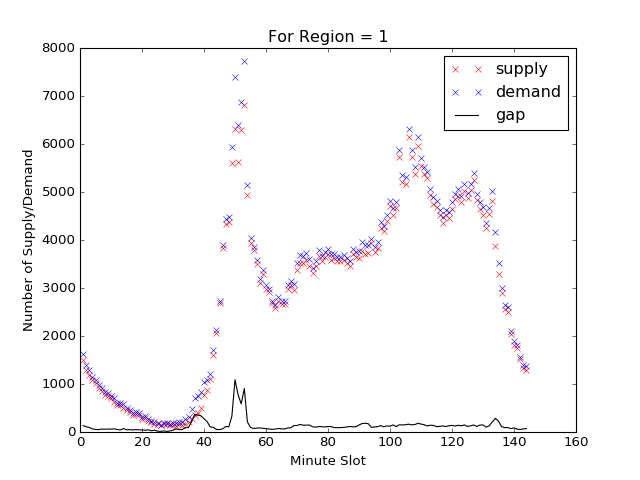

<IPython.core.display.Javascript object>


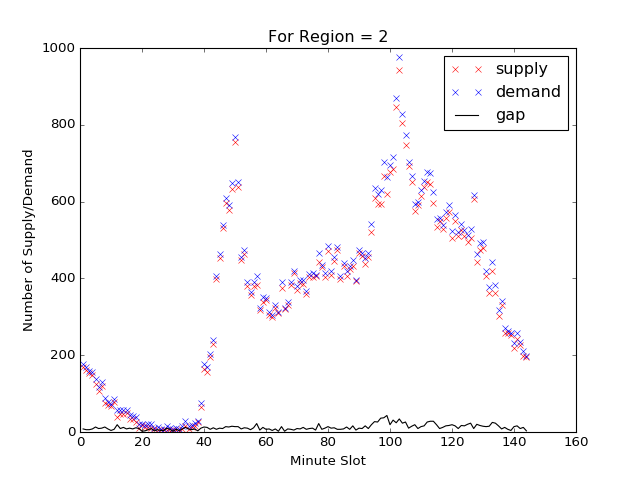

<IPython.core.display.Javascript object>


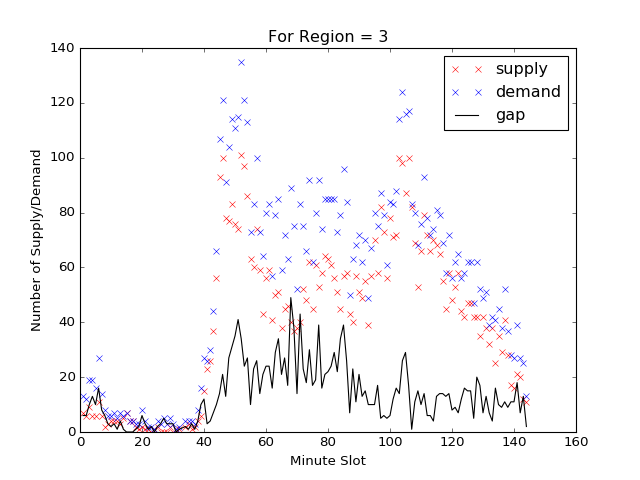

<IPython.core.display.Javascript object>


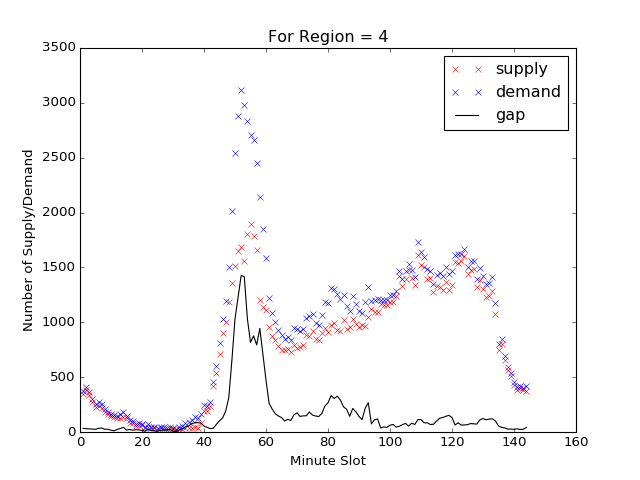

<IPython.core.display.Javascript object>


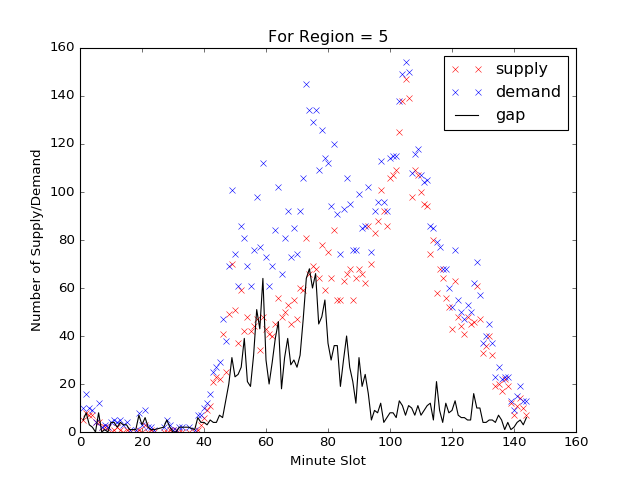

<IPython.core.display.Javascript object>


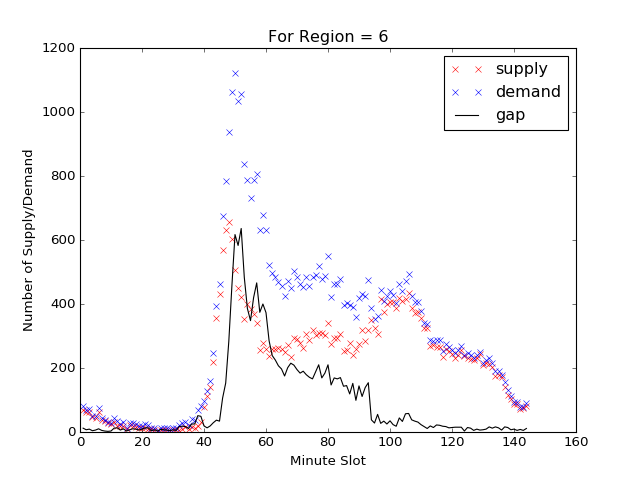

<IPython.core.display.Javascript object>


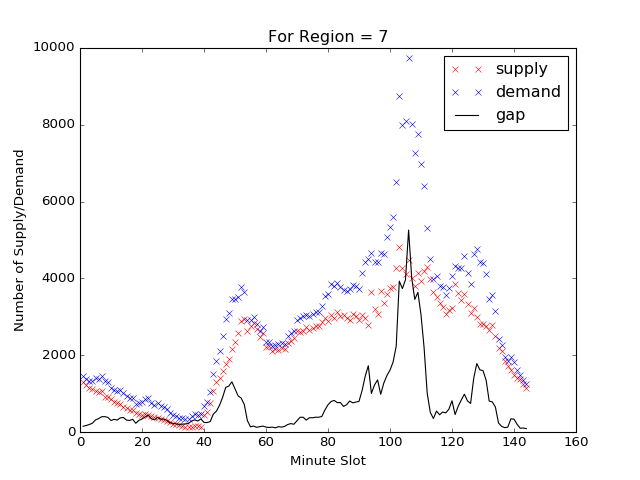

<IPython.core.display.Javascript object>


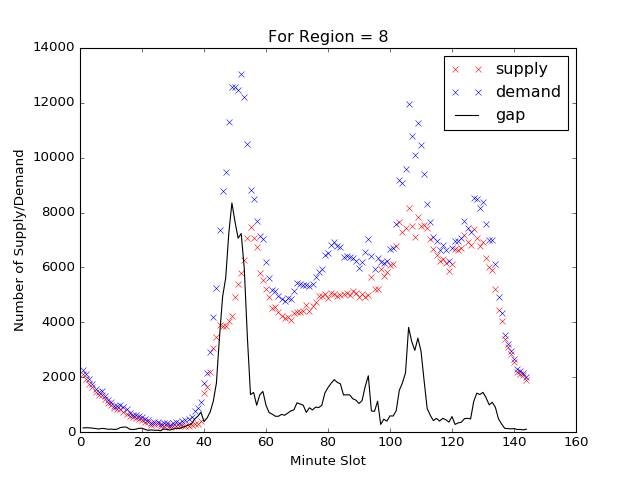

<IPython.core.display.Javascript object>


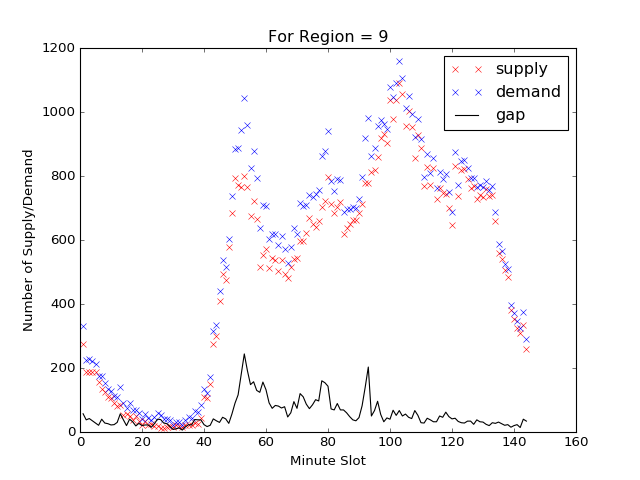

<IPython.core.display.Javascript object>


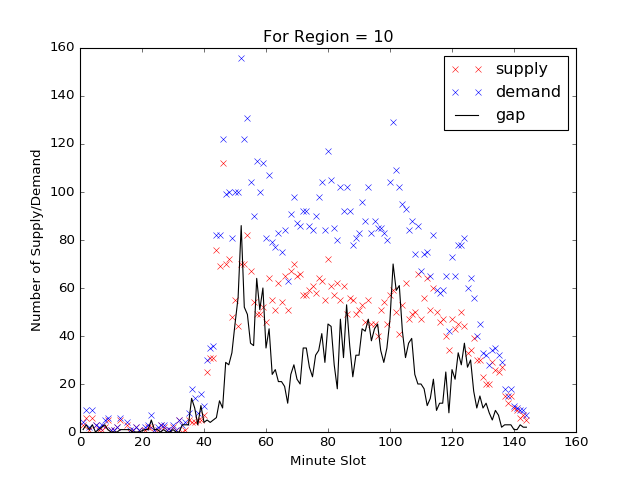

<IPython.core.display.Javascript object>


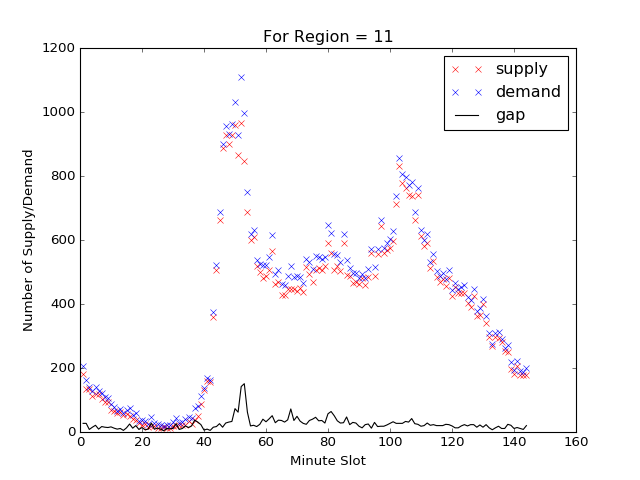

<IPython.core.display.Javascript object>


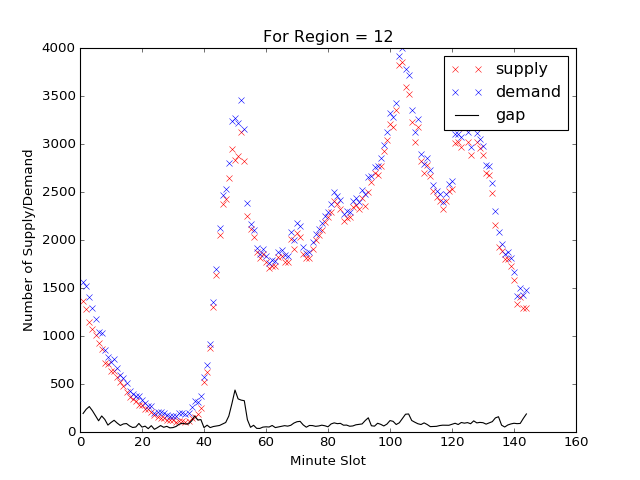

<IPython.core.display.Javascript object>


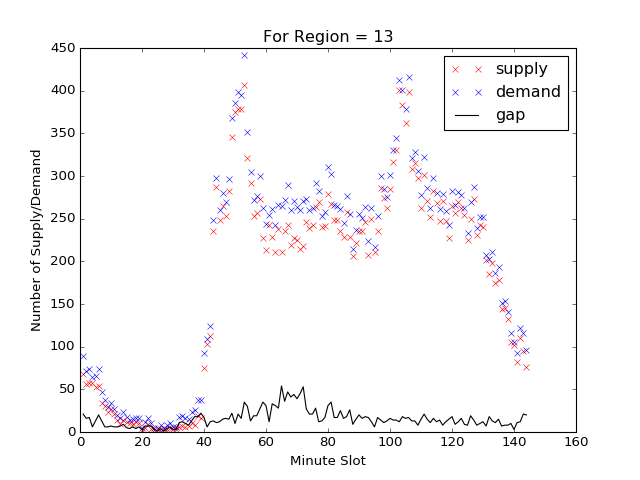

<IPython.core.display.Javascript object>


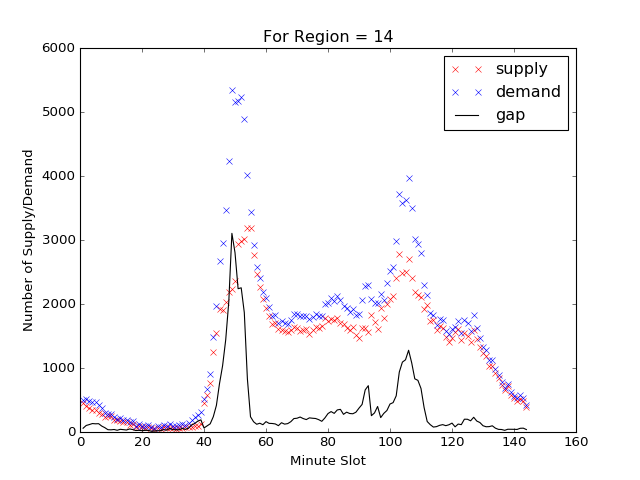

<IPython.core.display.Javascript object>


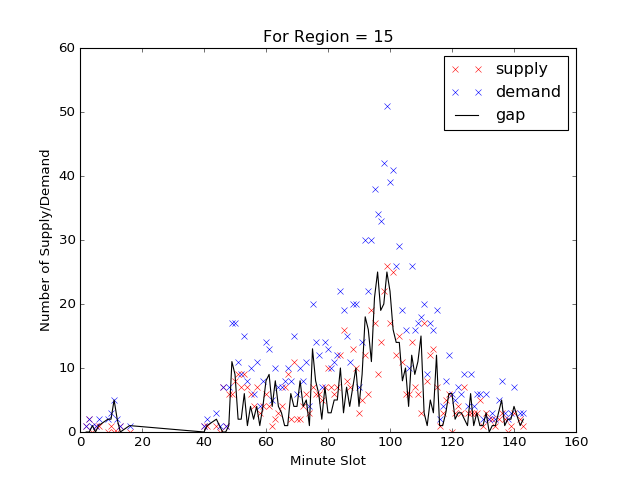

<IPython.core.display.Javascript object>


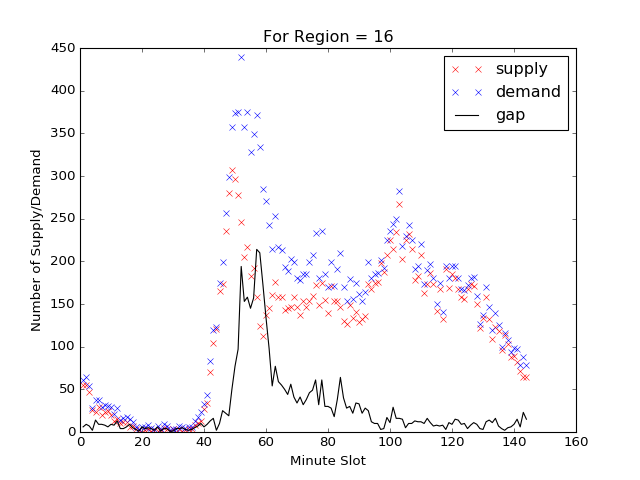

<IPython.core.display.Javascript object>


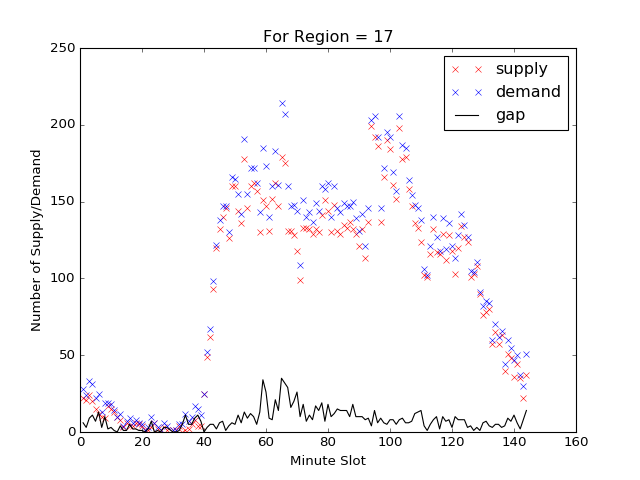

<IPython.core.display.Javascript object>


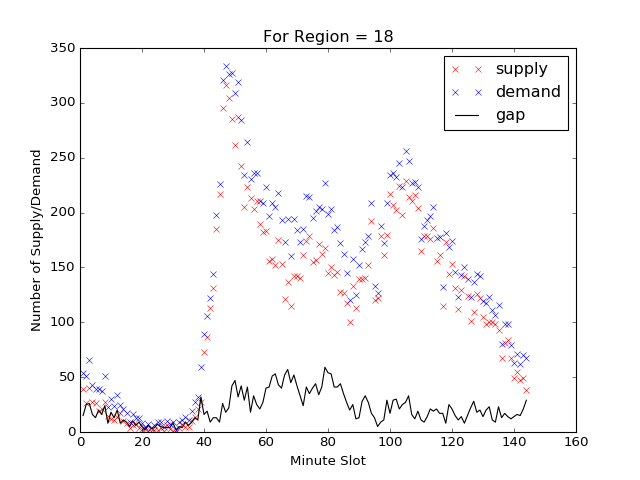

<IPython.core.display.Javascript object>


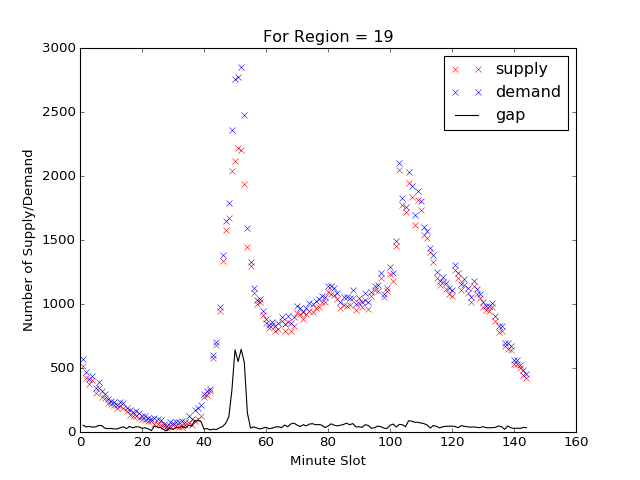

<IPython.core.display.Javascript object>


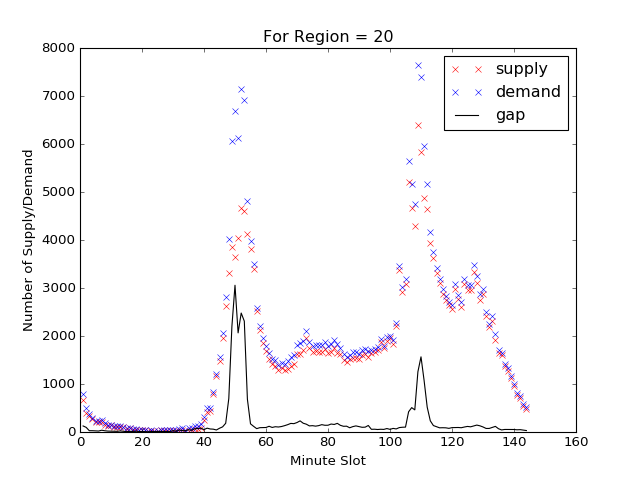

<IPython.core.display.Javascript object>


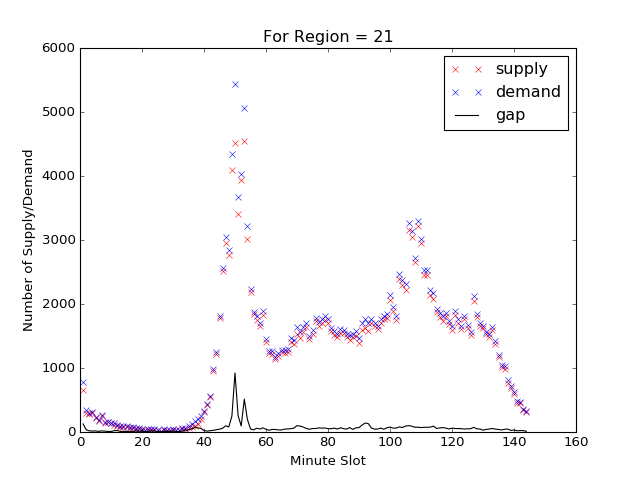

<IPython.core.display.Javascript object>


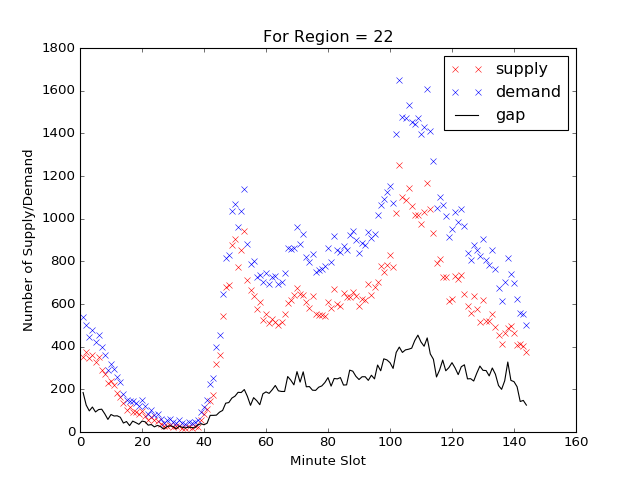

<IPython.core.display.Javascript object>


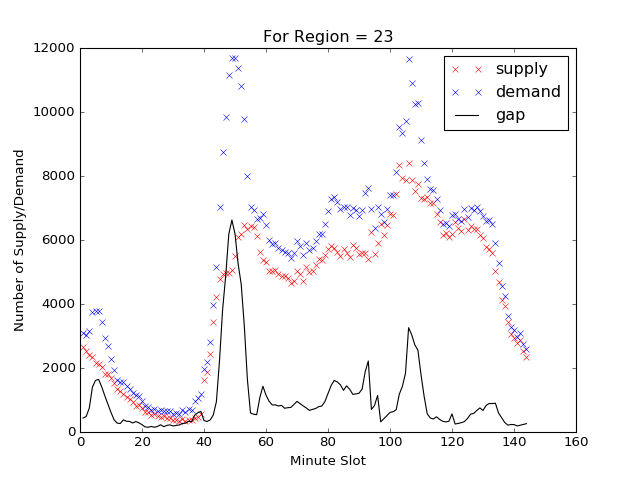

<IPython.core.display.Javascript object>


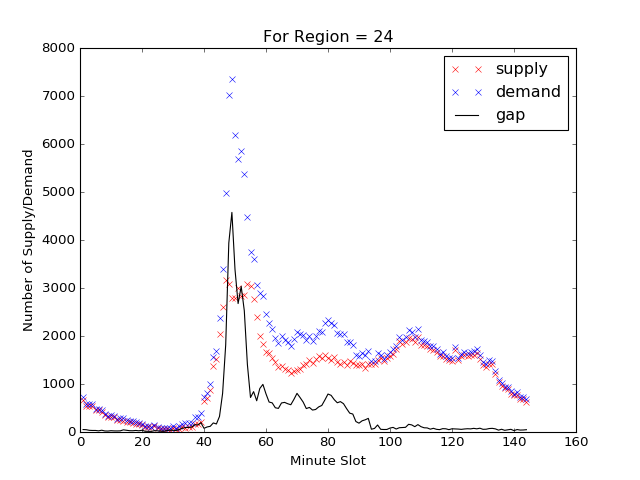

<IPython.core.display.Javascript object>


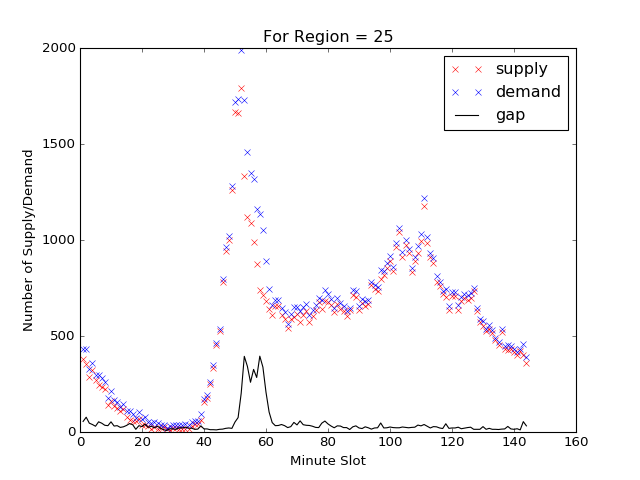

<IPython.core.display.Javascript object>


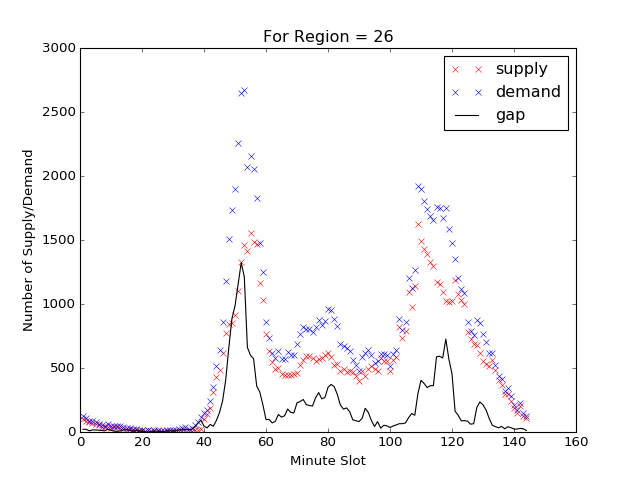

<IPython.core.display.Javascript object>


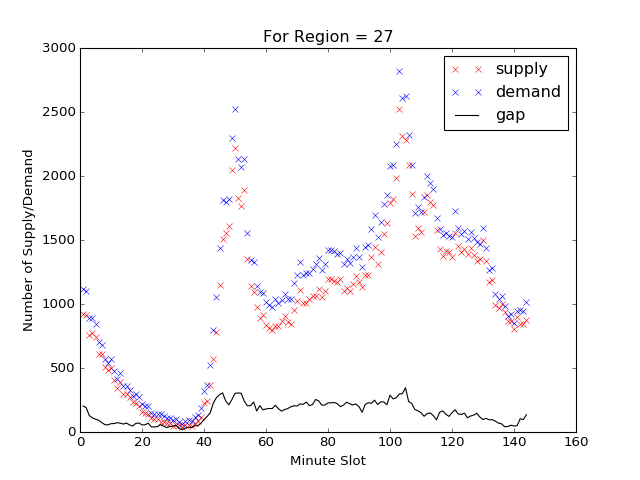

<IPython.core.display.Javascript object>


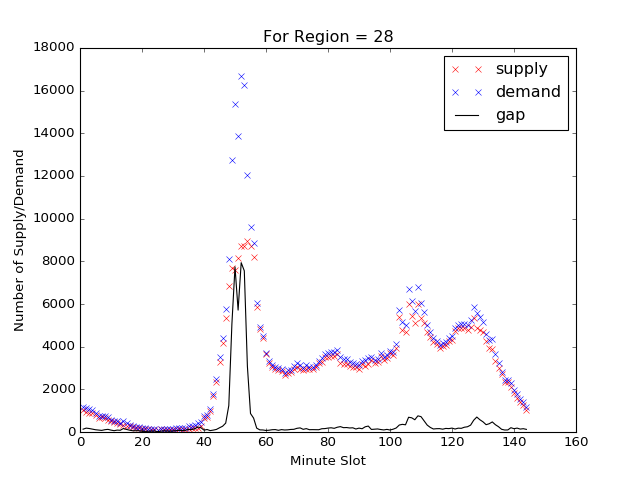

<IPython.core.display.Javascript object>


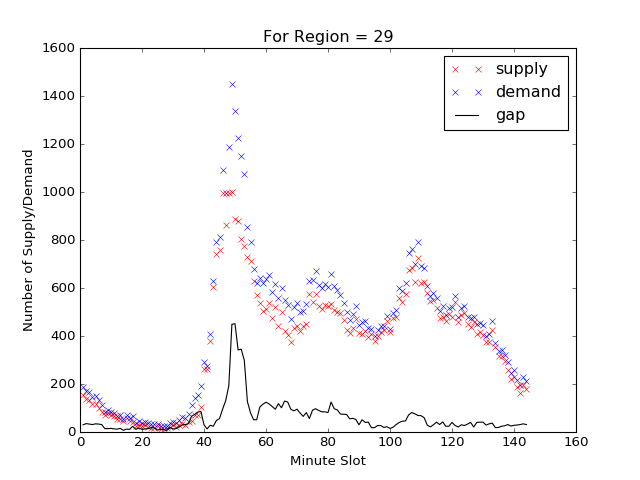

<IPython.core.display.Javascript object>


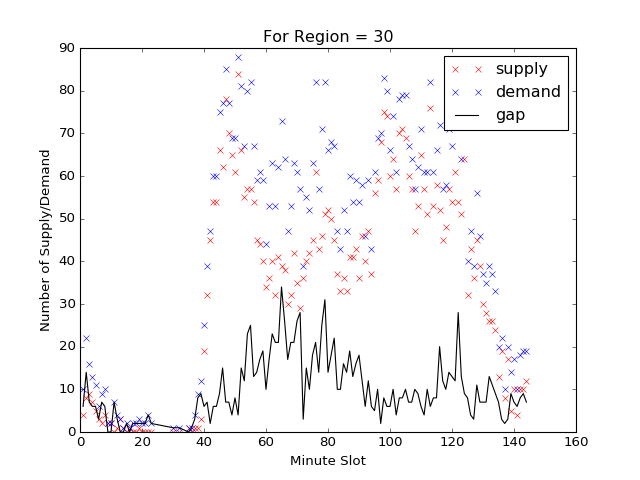

<IPython.core.display.Javascript object>


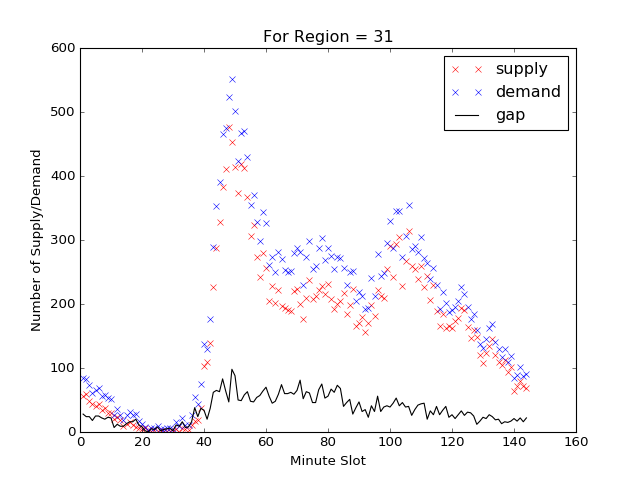

<IPython.core.display.Javascript object>


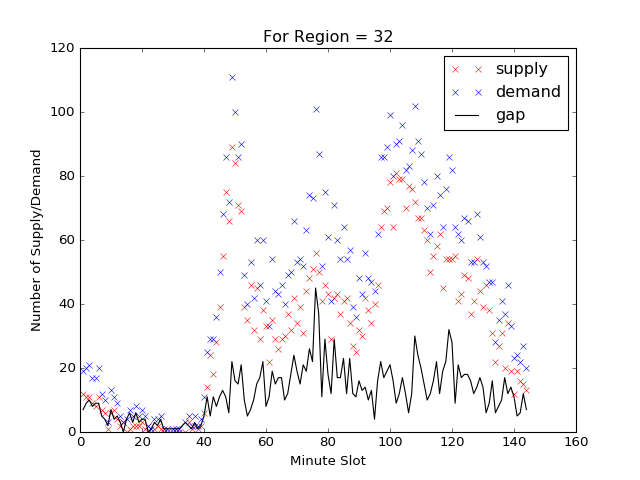

<IPython.core.display.Javascript object>


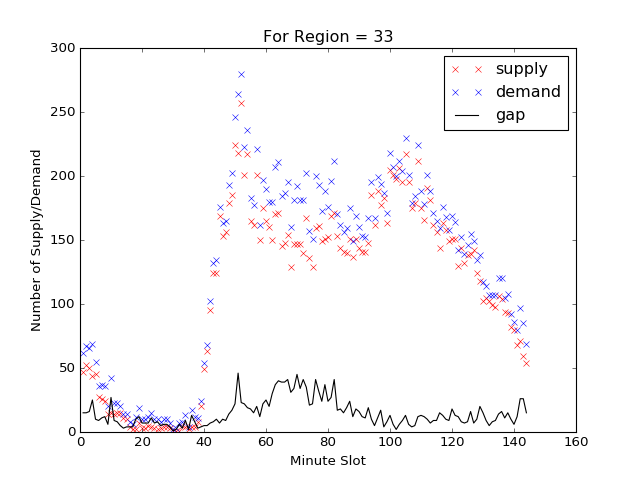

<IPython.core.display.Javascript object>


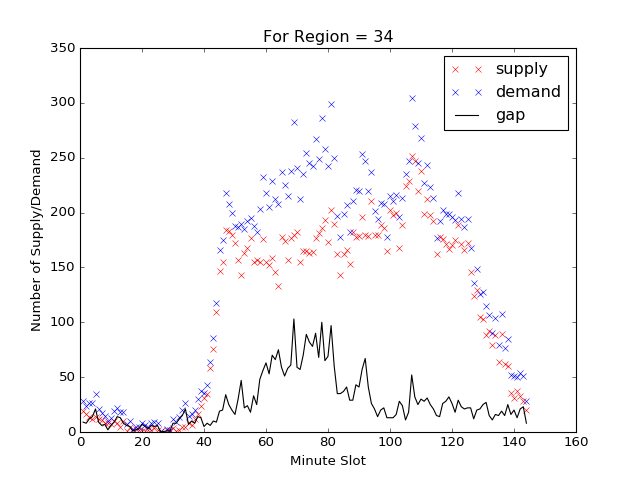

<IPython.core.display.Javascript object>


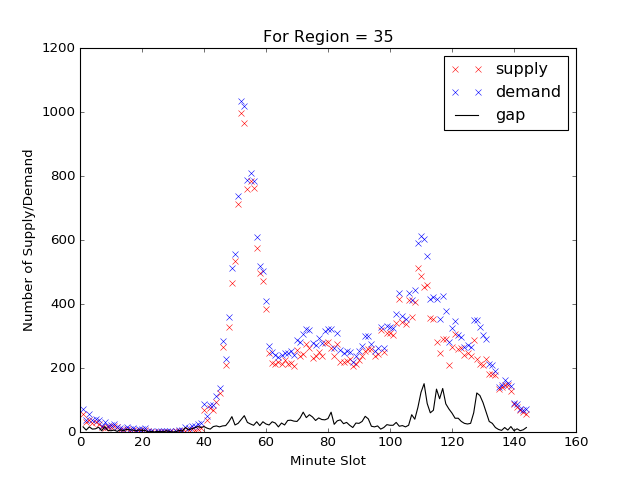

<IPython.core.display.Javascript object>


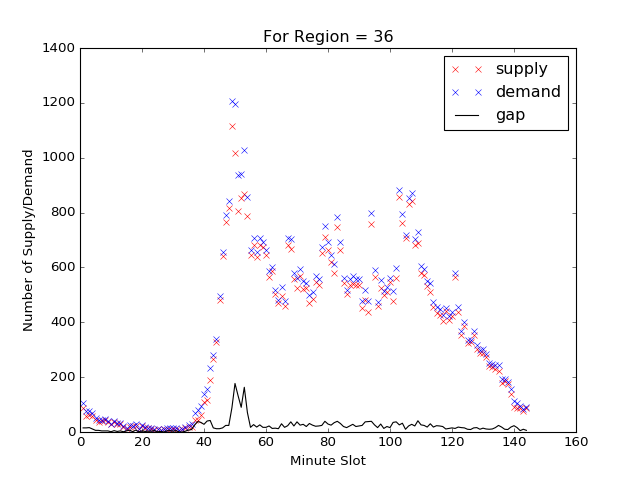

<IPython.core.display.Javascript object>


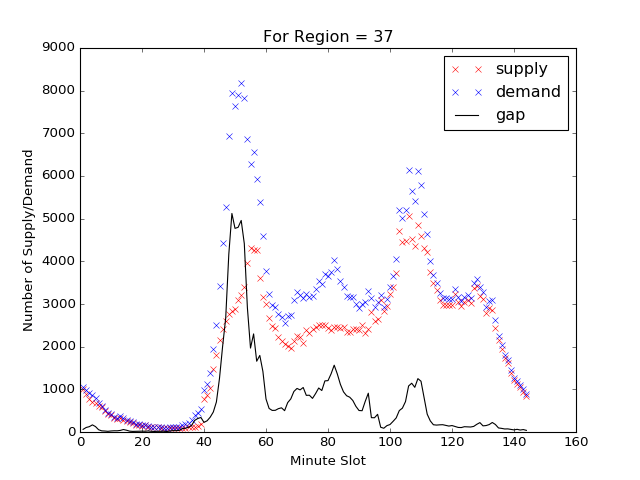

<IPython.core.display.Javascript object>


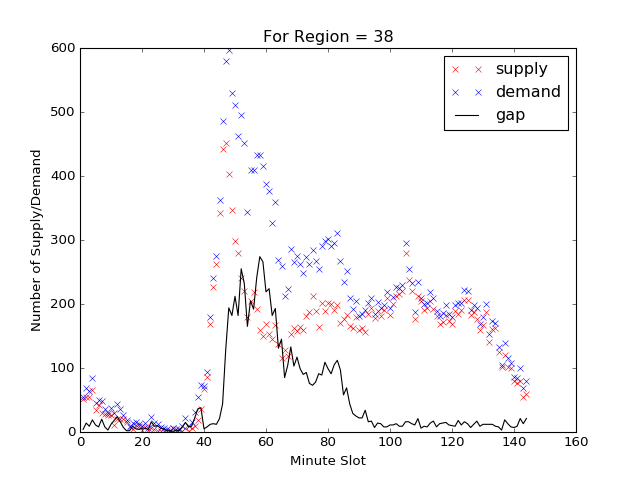

<IPython.core.display.Javascript object>


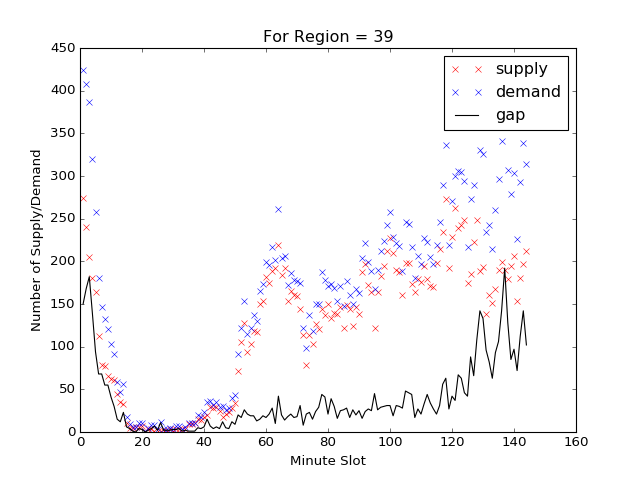

<IPython.core.display.Javascript object>


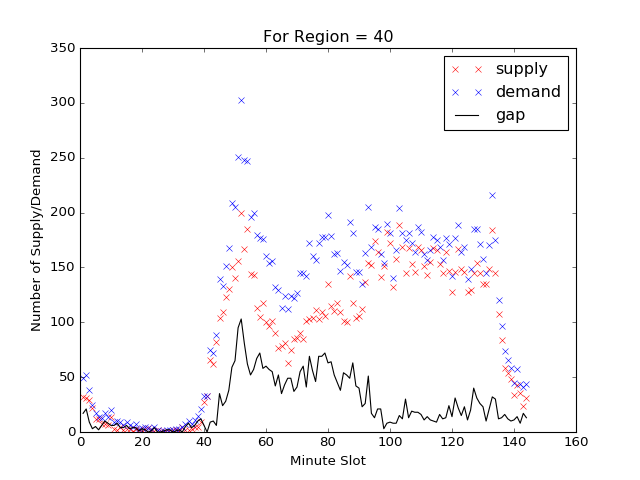

<IPython.core.display.Javascript object>


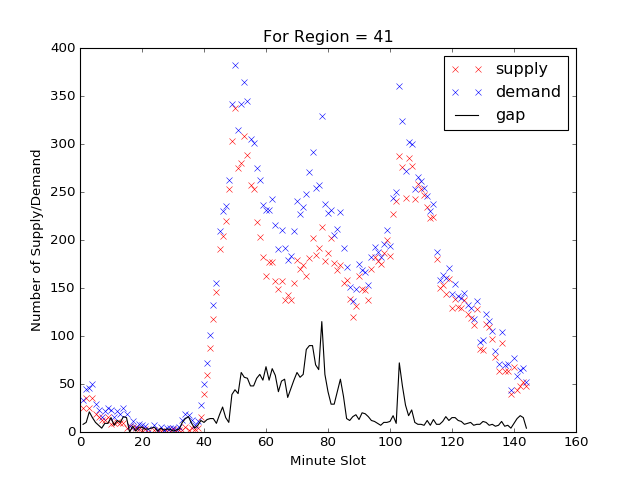

<IPython.core.display.Javascript object>


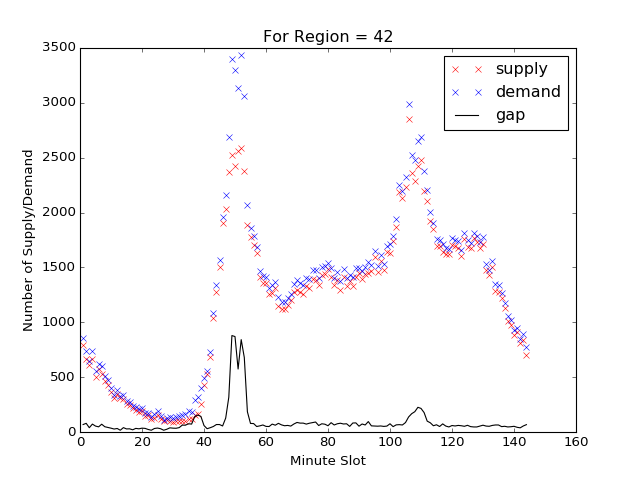

<IPython.core.display.Javascript object>


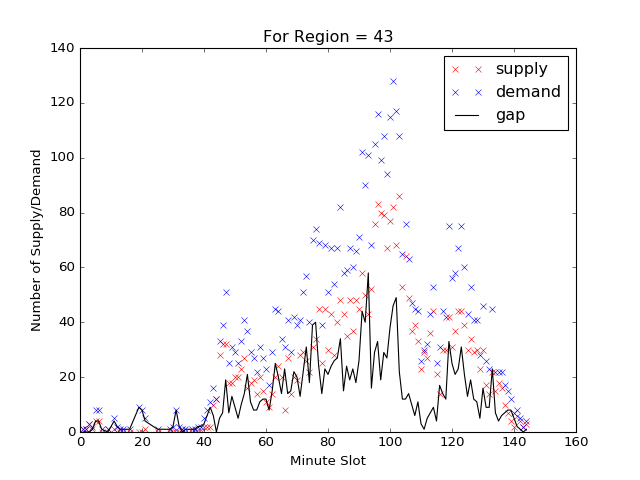

<IPython.core.display.Javascript object>


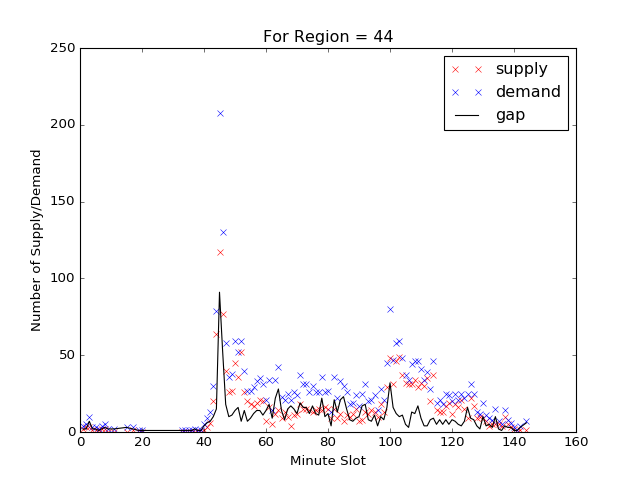

<IPython.core.display.Javascript object>


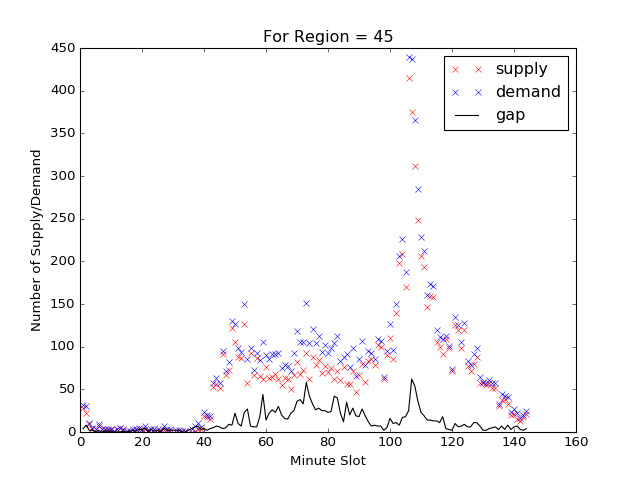

<IPython.core.display.Javascript object>


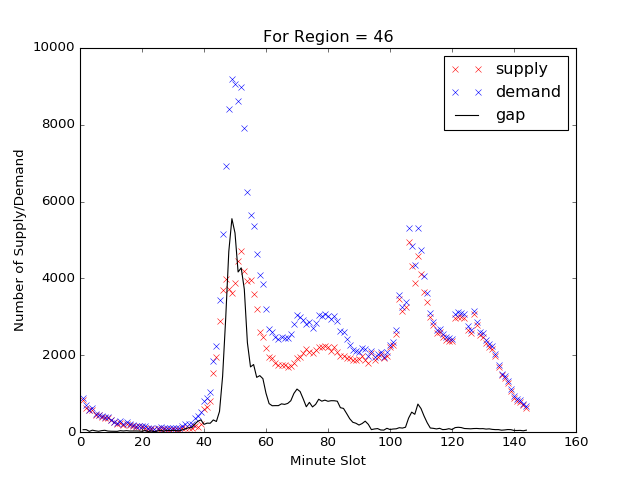

<IPython.core.display.Javascript object>


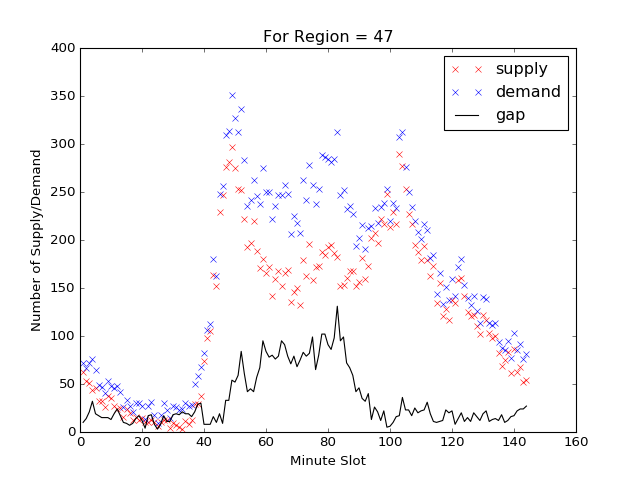

<IPython.core.display.Javascript object>


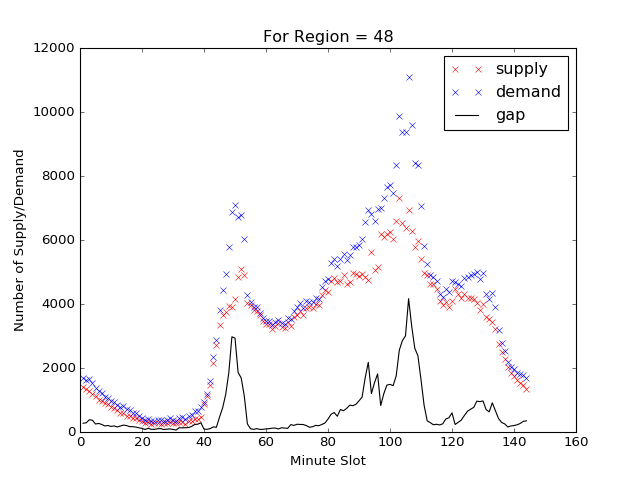

<IPython.core.display.Javascript object>


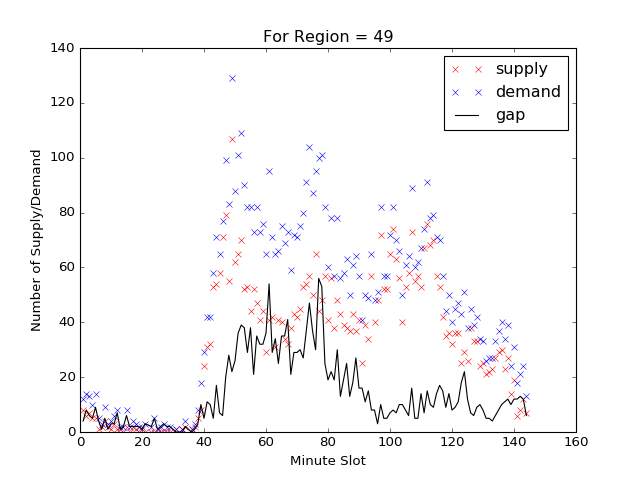

<IPython.core.display.Javascript object>


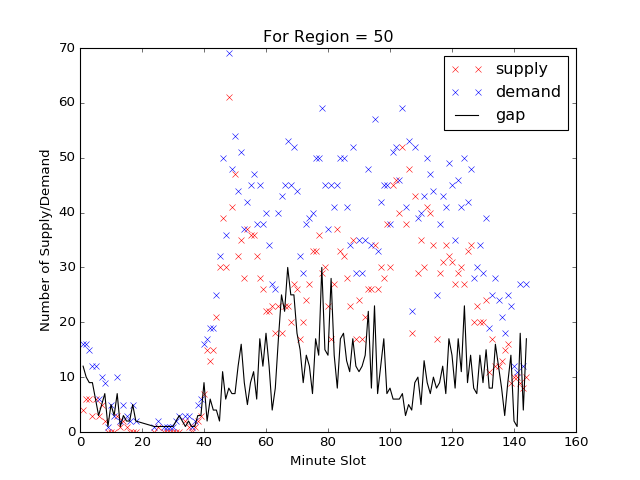

<IPython.core.display.Javascript object>


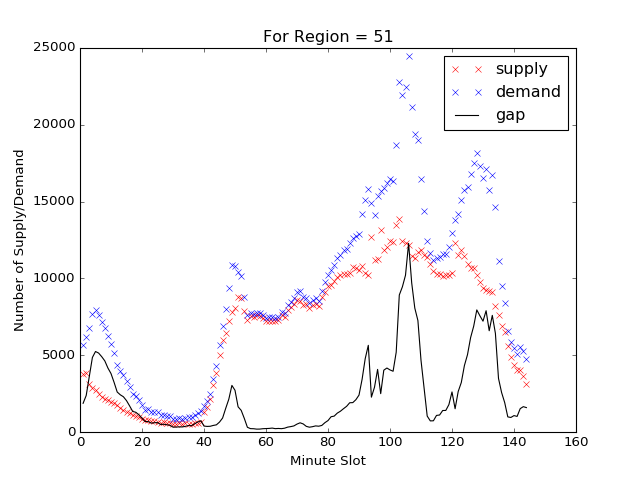

<IPython.core.display.Javascript object>


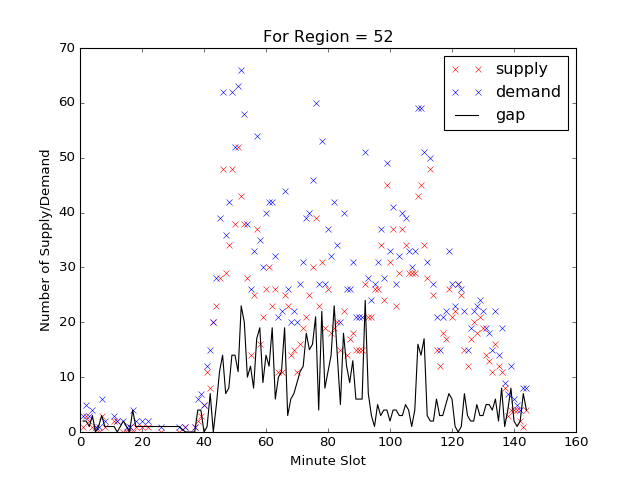

<IPython.core.display.Javascript object>


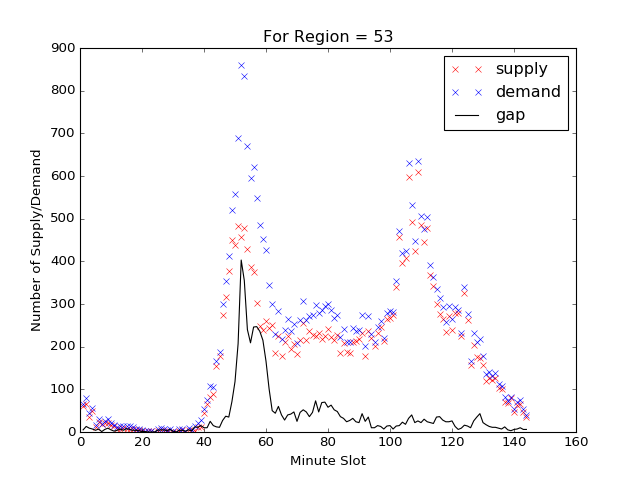

<IPython.core.display.Javascript object>


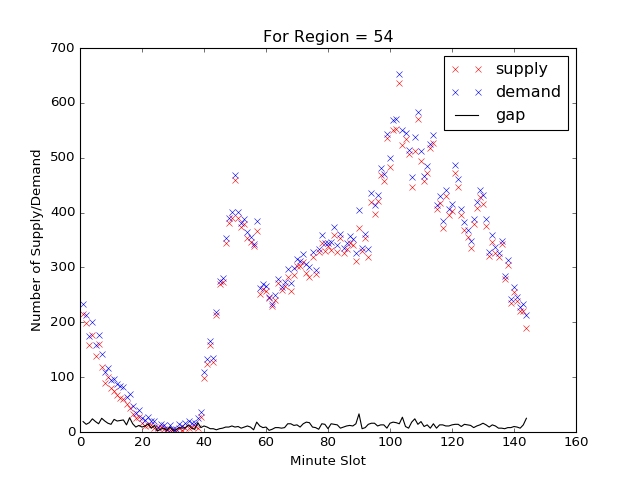

<IPython.core.display.Javascript object>


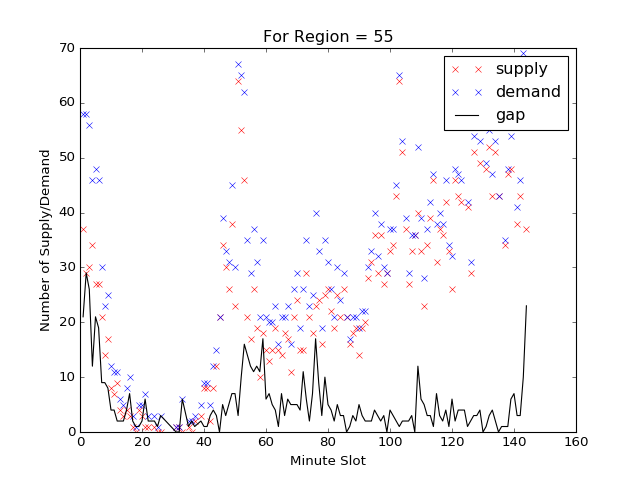

<IPython.core.display.Javascript object>


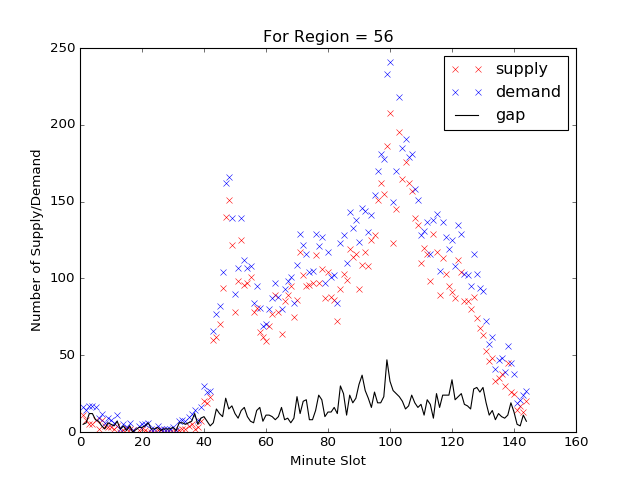

<IPython.core.display.Javascript object>


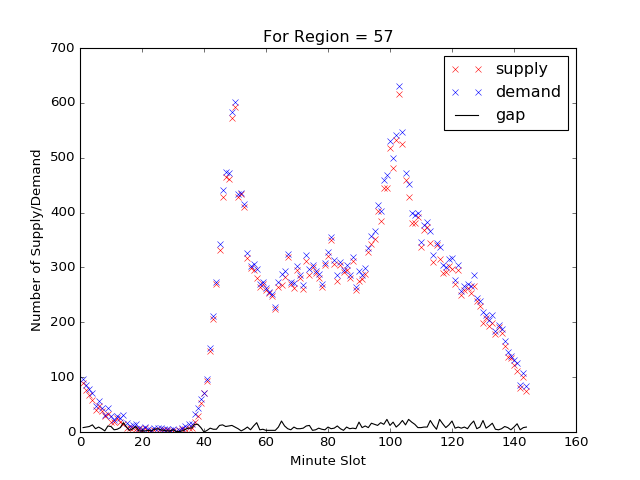

<IPython.core.display.Javascript object>


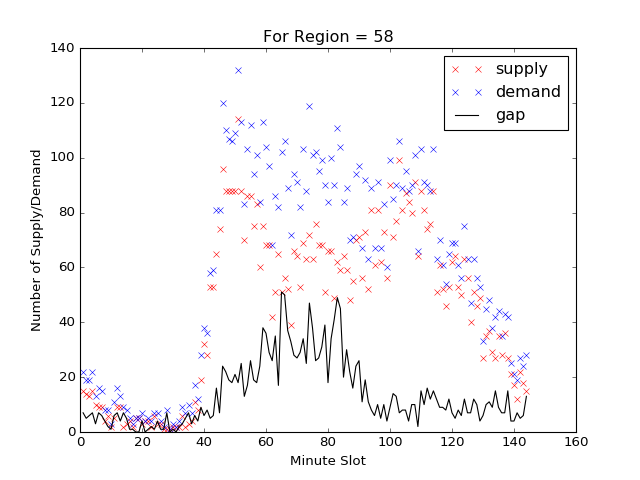

<IPython.core.display.Javascript object>


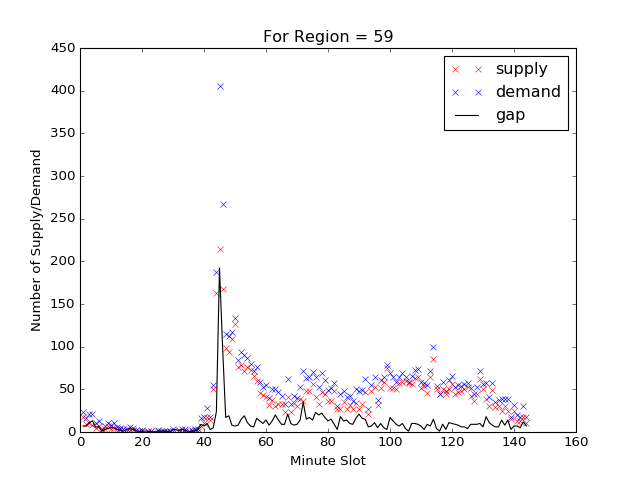

<IPython.core.display.Javascript object>


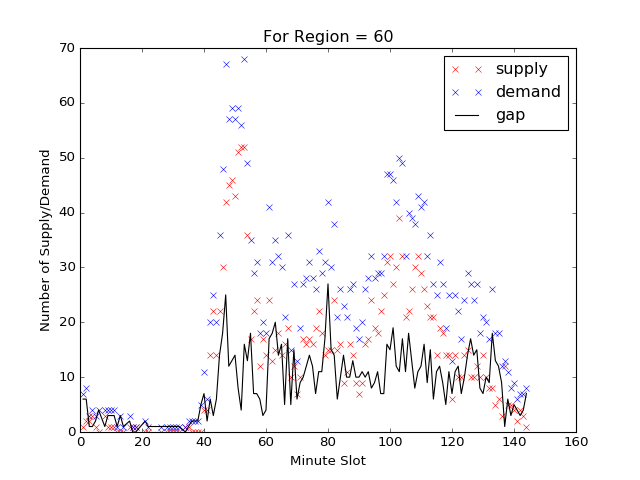

<IPython.core.display.Javascript object>


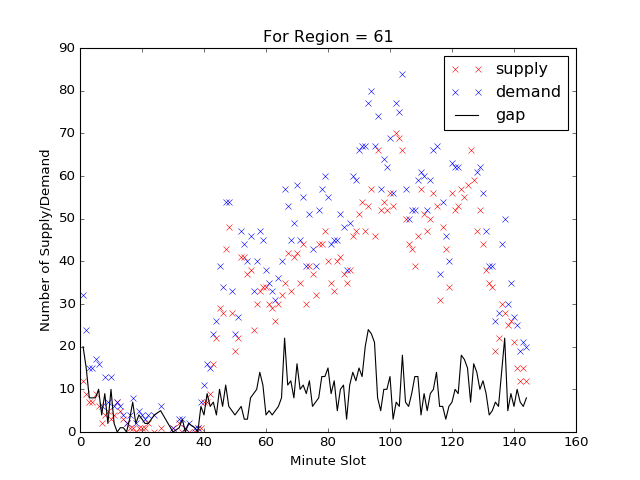

<IPython.core.display.Javascript object>


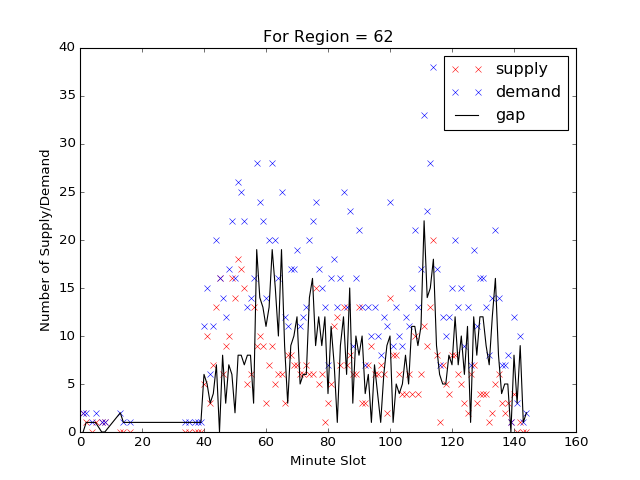

<IPython.core.display.Javascript object>


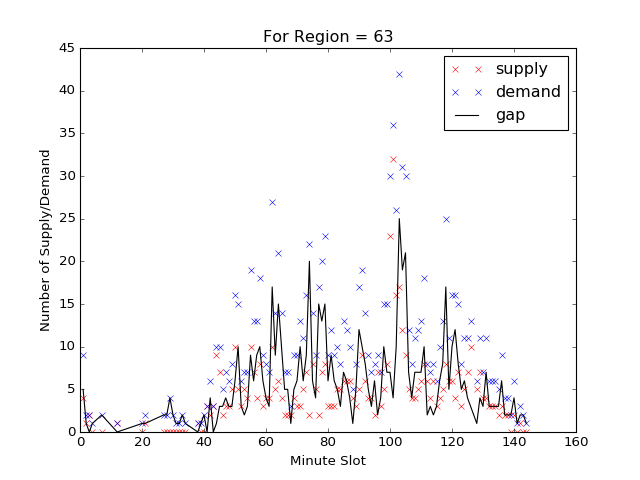

<IPython.core.display.Javascript object>


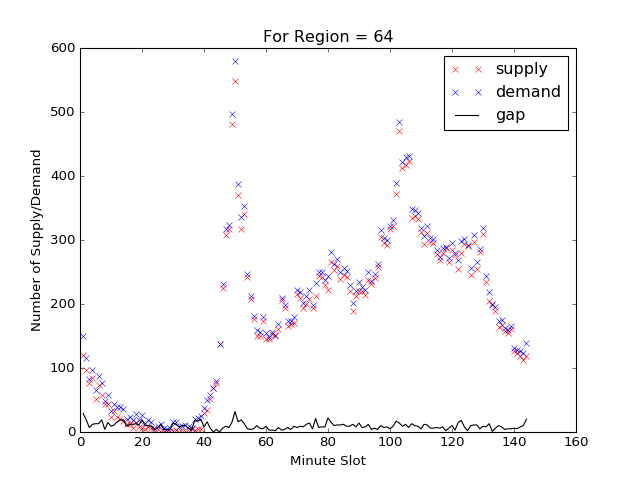

<IPython.core.display.Javascript object>


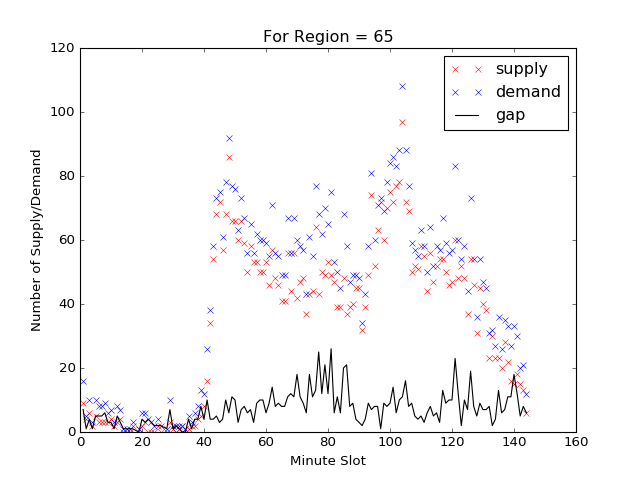

<IPython.core.display.Javascript object>


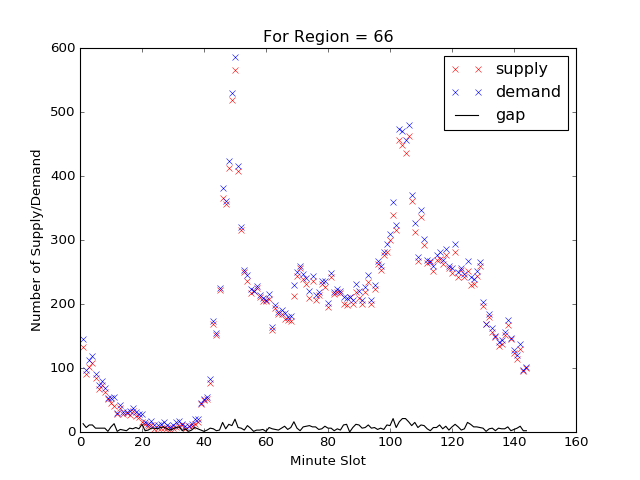

In [21]:
#fig, axs=plt.subplots(nrows=11, ncols=6,)
def PlotRegions(X, supply, demand, colors=['r','b','k']):
    for r in regions: 
        idx=r-1
        fig, axs=plt.subplots()
        axs.plot(X[X[:,0]==r, 1], supply[X[:,0]==r], colors[0]+'x', label='supply')
        axs.plot(X[X[:,0]==r, 1], demand[X[:,0]==r], colors[1]+'x', label='demand')
        axs.plot(X[X[:,0]==r, 1], demand[X[:,0]==r]-supply[X[:,0]==r], colors[0]+'-', label='gap')
        plt.xlabel('Minute Slot')
        plt.ylabel('Number of Supply/Demand')
        plt.title('For Region = {}'.format(r))
        plt.legend()
PlotRegions(X, supply, demand)

<IPython.core.display.Javascript object>


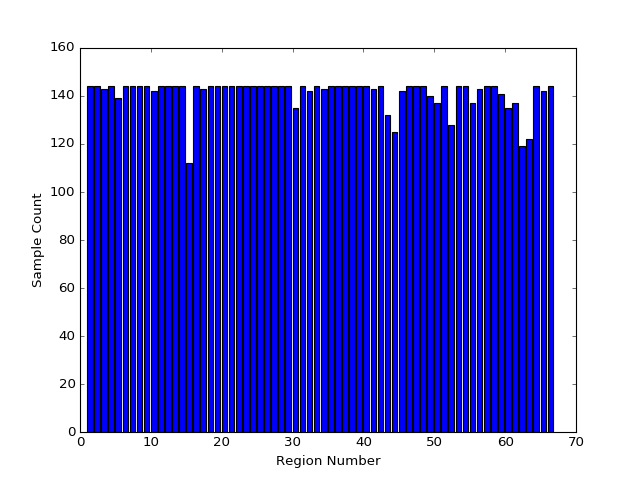

In [8]:
def PlotRegionCounts(X, ax):
    regioncounts = np.zeros((numregions,))
    for r in regions:
        regioncounts[r-1] = np.sum(X[:, 0]==(r))
    ax.bar(regions, regioncounts)
    ax.set_xlabel('Region Number')
    ax.set_ylabel('Sample Count')
fig, ax = plt.subplots()
PlotRegionCounts(X, ax)

In [9]:
def SplitByRegion(X, supply, demand, splitfrac):
    Xtrain, supplyTrain, demandTrain = None, None, None
    Xval, supplyVal, demandVal = None, None, None
    
    for r in regions:
        Xr, supplyr, demandr = X[X[:, 0]==r], supply[X[:, 0]==r], demand[X[:, 0]==r]
        randidx = np.random.choice(Xr.shape[0], (Xr.shape[0],), replace=False)
        cut = int(Xr.shape[0]*splitfrac)
        
        if Xtrain is None: 
            Xtrain, supplyTrain, demandTrain = Xr[randidx[:cut]], supplyr[randidx[:cut]], demandr[randidx[:cut]]
            Xval, supplyVal, demandVal = Xr[randidx[cut:]], supplyr[randidx[cut:]], demandr[randidx[cut:]]
        else:
            Xrtrain, supplyrTrain, demandrTrain = Xr[randidx[:cut]], supplyr[randidx[:cut]], demandr[randidx[:cut]]
            Xrval, supplyrVal, demandrVal = Xr[randidx[cut:]], supplyr[randidx[cut:]], demandr[randidx[cut:]]
            
            Xtrain = np.concatenate((Xtrain, Xrtrain))
            supplyTrain = np.concatenate((supplyTrain, supplyrTrain))
            demandTrain = np.concatenate((demandTrain, demandrTrain))
            
            Xval = np.concatenate((Xval, Xrval))
            supplyVal = np.concatenate((supplyVal, supplyrVal))
            demandVal = np.concatenate((demandVal, demandrVal))
    return Xtrain, supplyTrain, demandTrain, Xval, supplyVal, demandVal

In [10]:
Xtrain, supplyTrain, demandTrain, Xval, supplyVal, demandVal = SplitByRegion(X, supply, demand, .7)

<IPython.core.display.Javascript object>


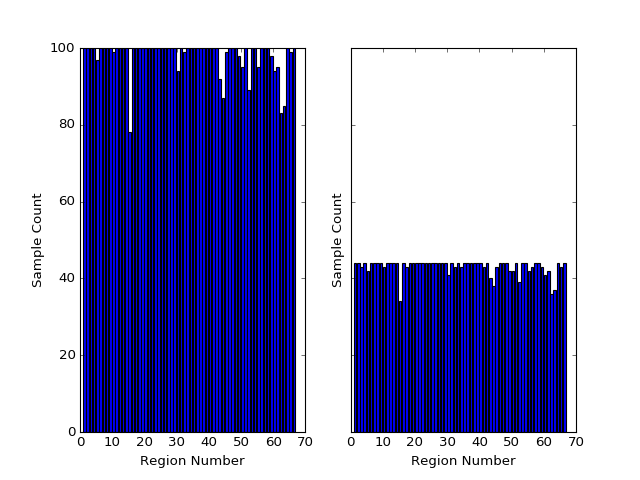

In [12]:
fig, ax = plt.subplots(ncols=2, sharey=True)
PlotRegionCounts(Xtrain, ax[0])
PlotRegionCounts(Xval, ax[1])

In [13]:
def getMAE(truths, preds): 
    return (np.sum(np.abs(truths-preds)))/(float(numtimeslots))

<IPython.core.display.Javascript object>


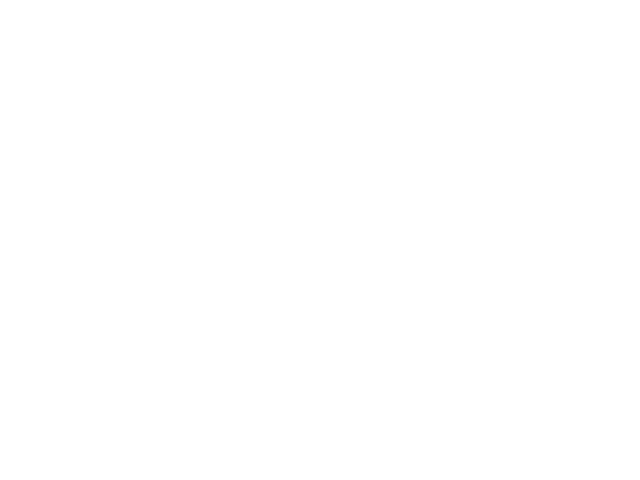

<IPython.core.display.Javascript object>


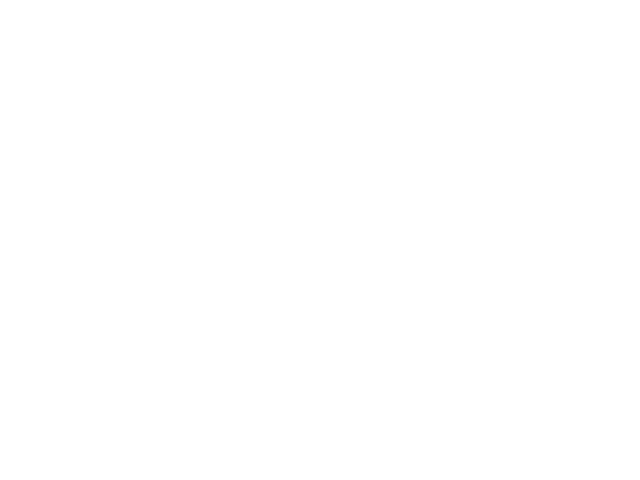

<IPython.core.display.Javascript object>


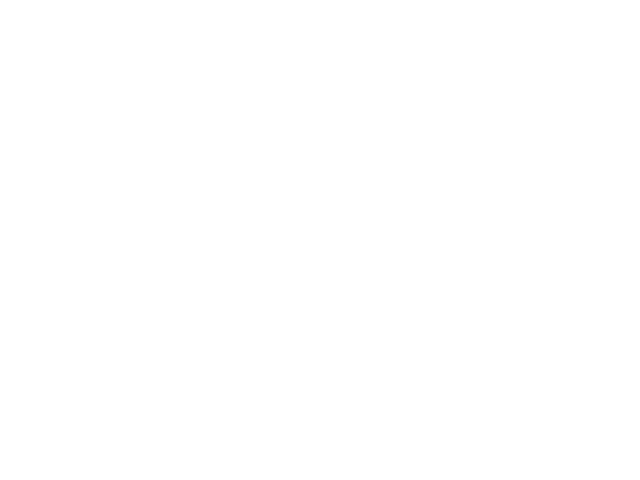

<IPython.core.display.Javascript object>


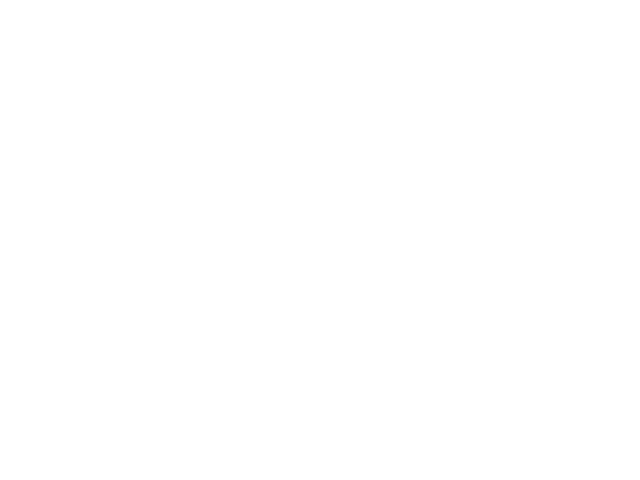

<IPython.core.display.Javascript object>


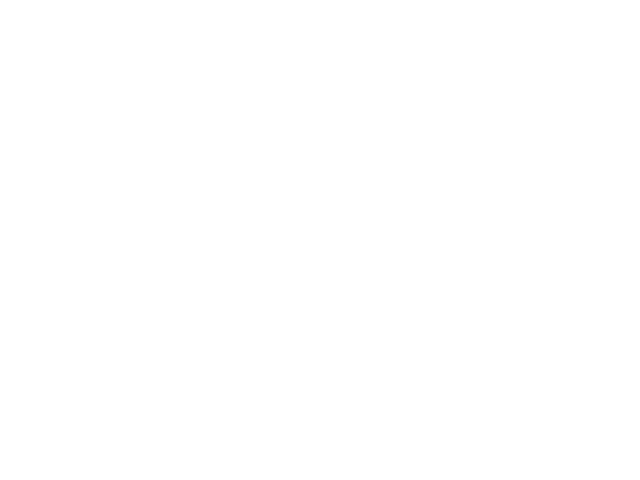

<IPython.core.display.Javascript object>


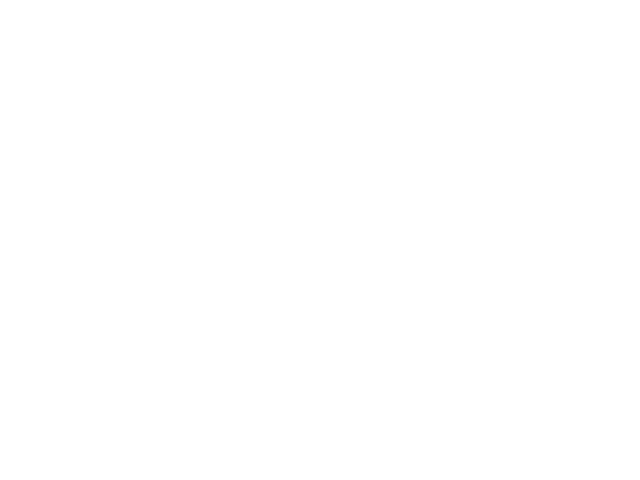

<IPython.core.display.Javascript object>


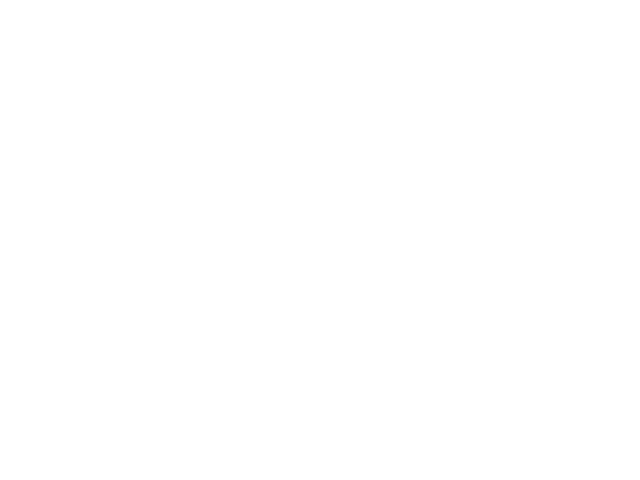

<IPython.core.display.Javascript object>


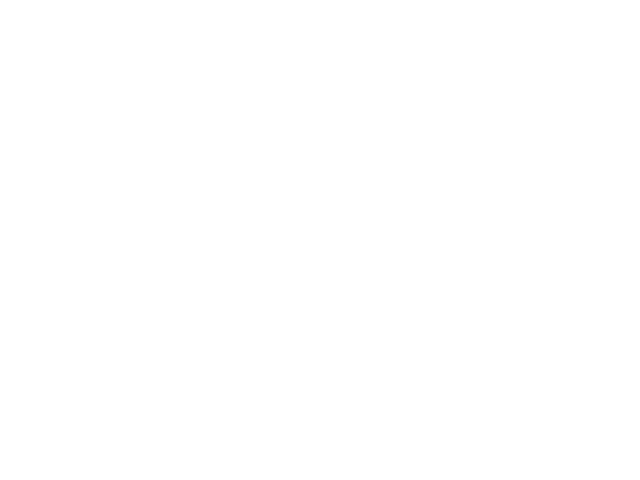

<IPython.core.display.Javascript object>


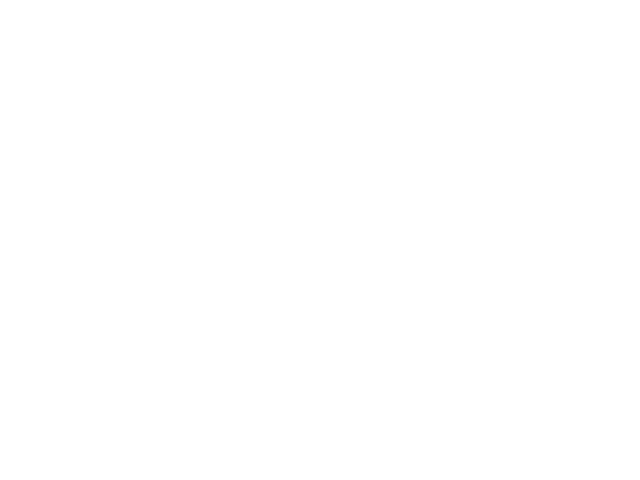

<IPython.core.display.Javascript object>


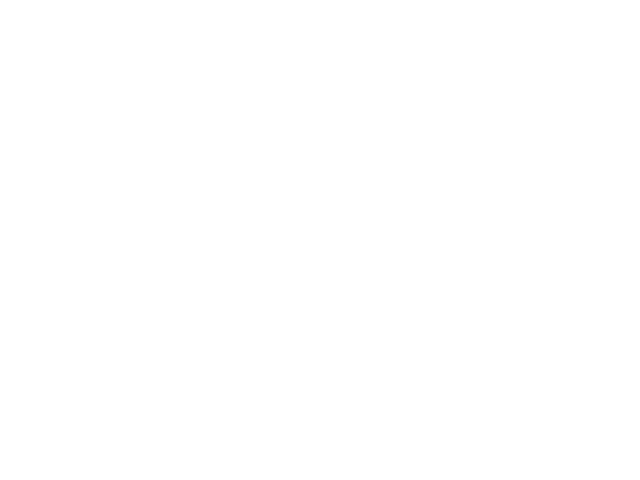

<IPython.core.display.Javascript object>


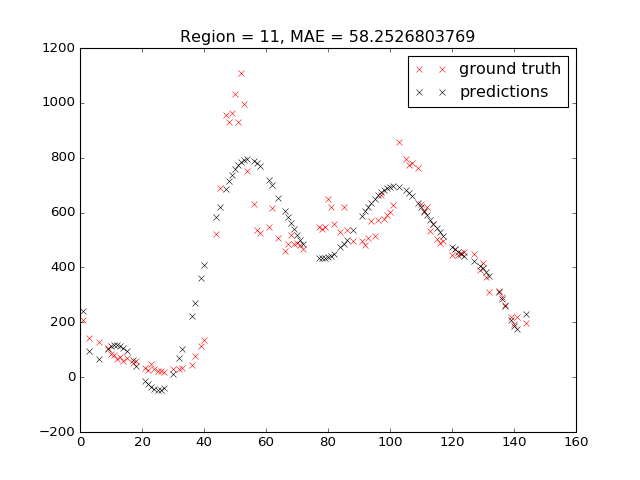

<IPython.core.display.Javascript object>


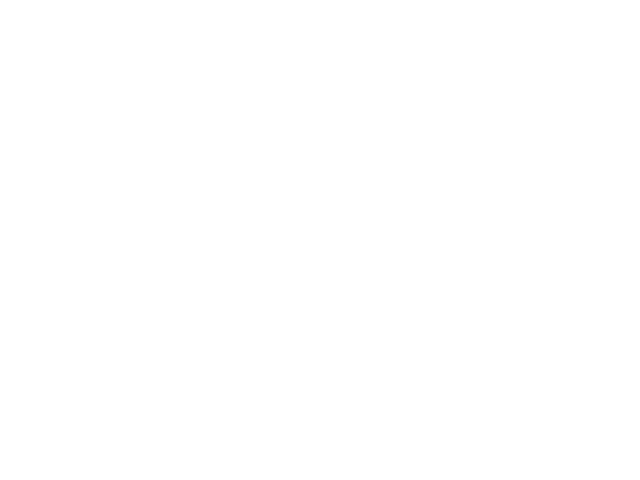

<IPython.core.display.Javascript object>


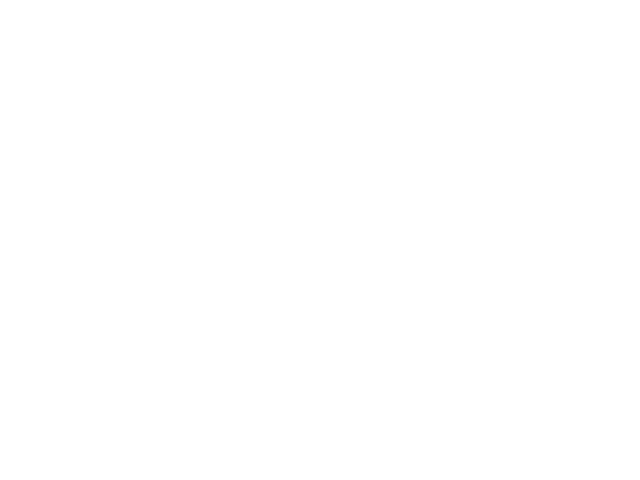

<IPython.core.display.Javascript object>


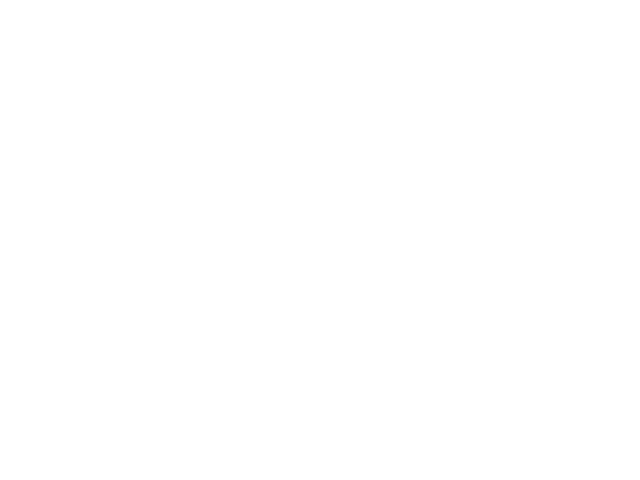

<IPython.core.display.Javascript object>


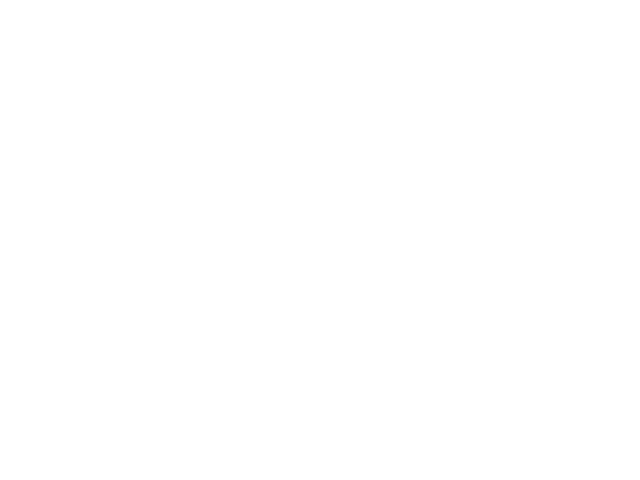

<IPython.core.display.Javascript object>


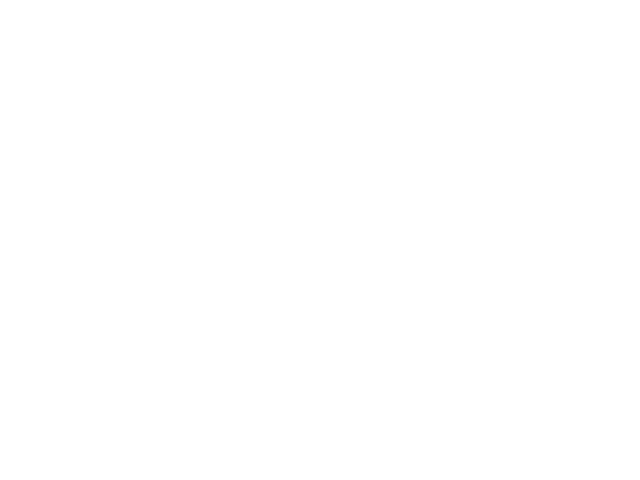

<IPython.core.display.Javascript object>


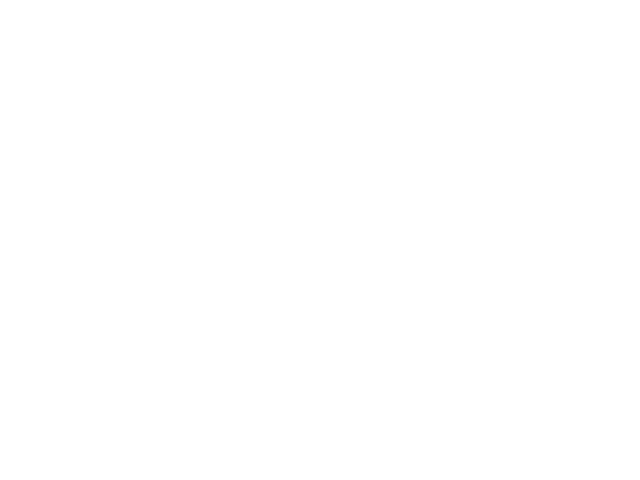

<IPython.core.display.Javascript object>


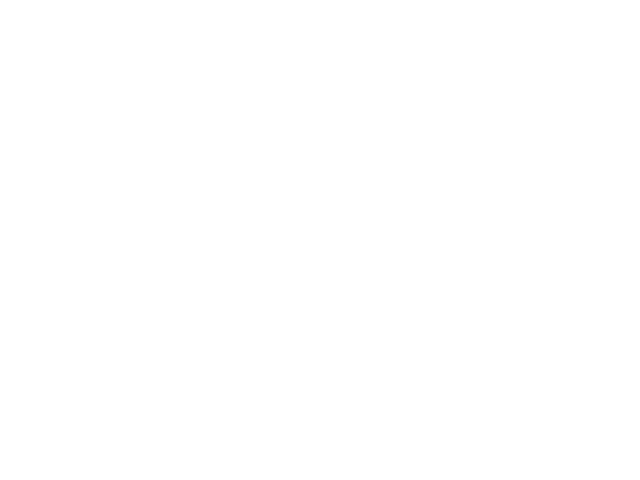

<IPython.core.display.Javascript object>


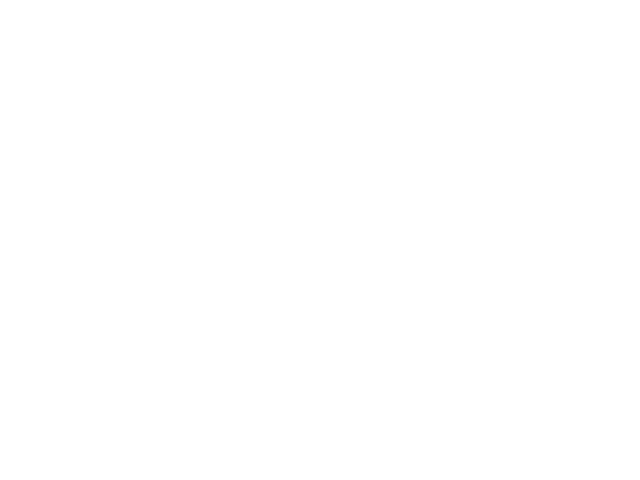

<IPython.core.display.Javascript object>


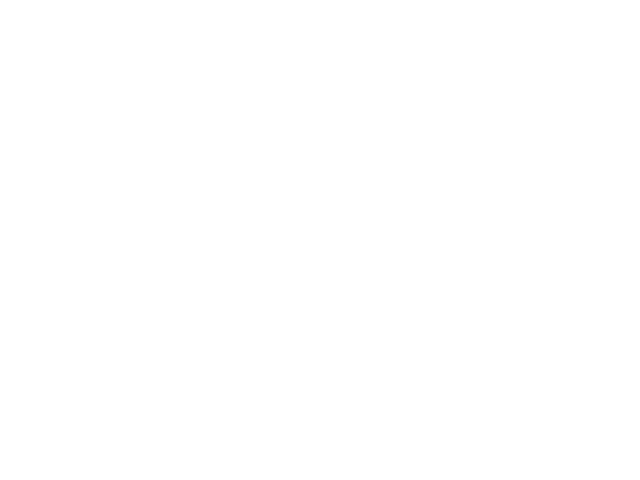

<IPython.core.display.Javascript object>


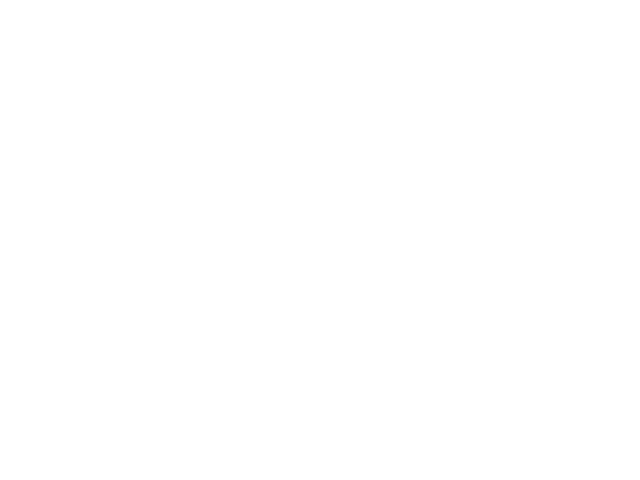

<IPython.core.display.Javascript object>


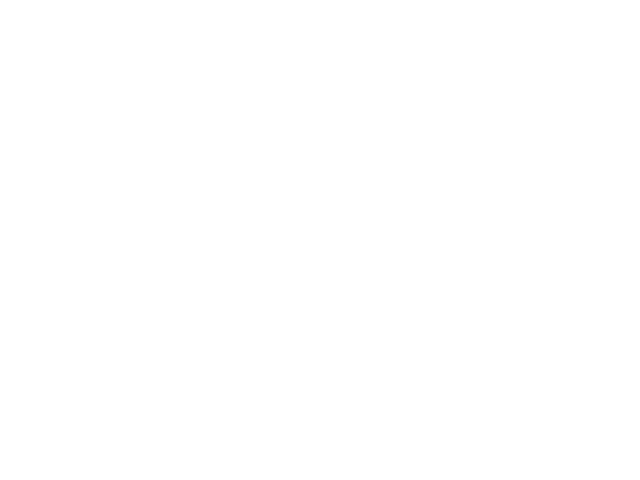

<IPython.core.display.Javascript object>


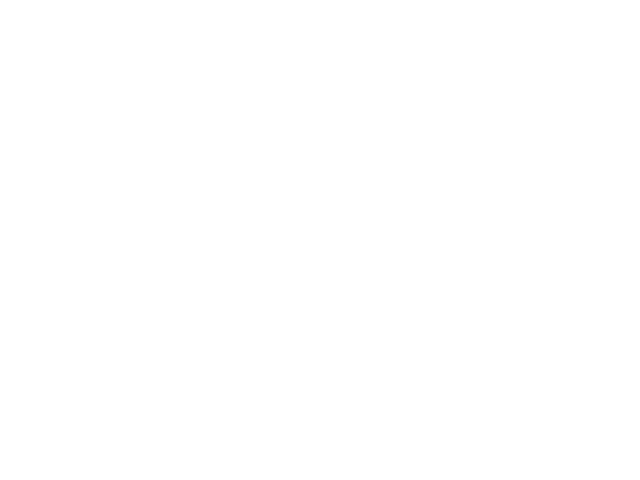

<IPython.core.display.Javascript object>


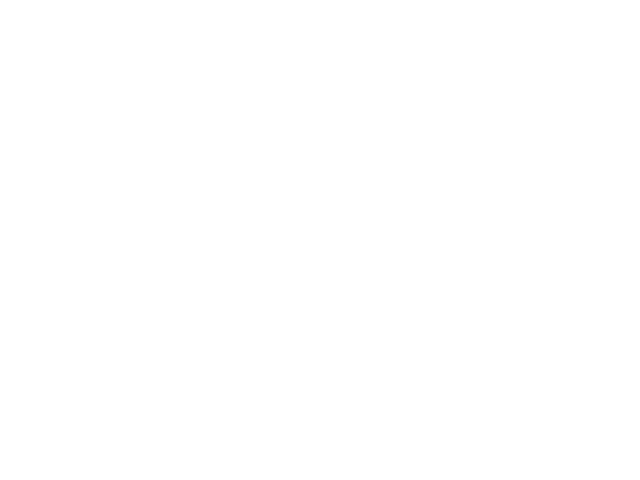

<IPython.core.display.Javascript object>


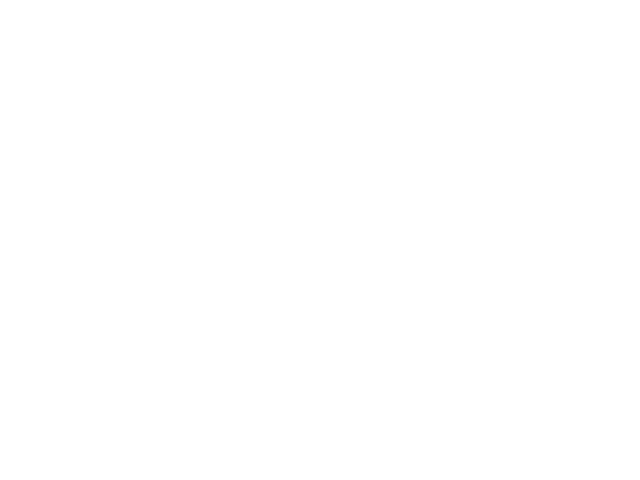

<IPython.core.display.Javascript object>


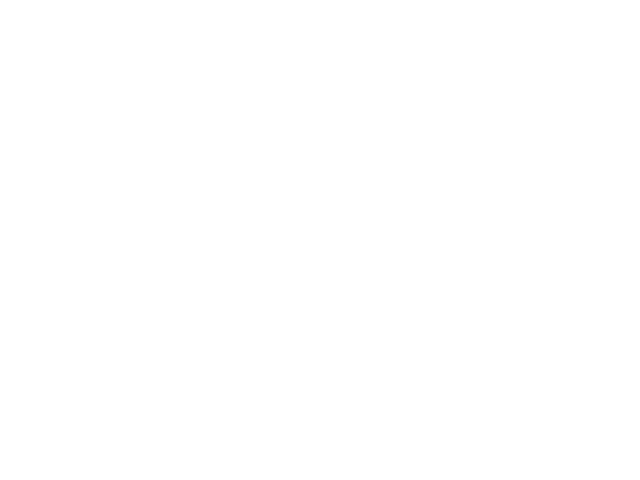

<IPython.core.display.Javascript object>


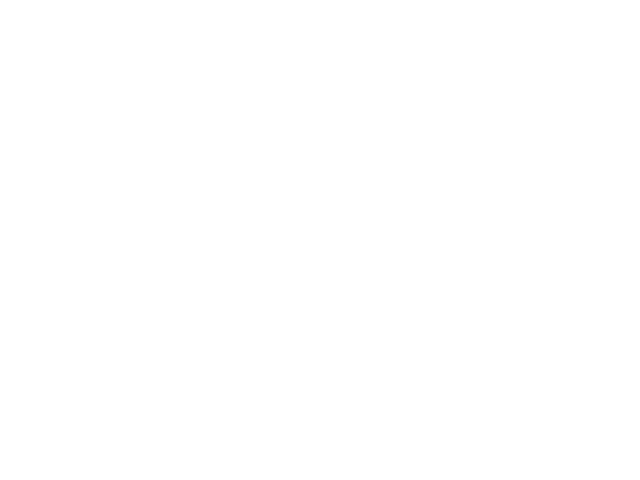

<IPython.core.display.Javascript object>


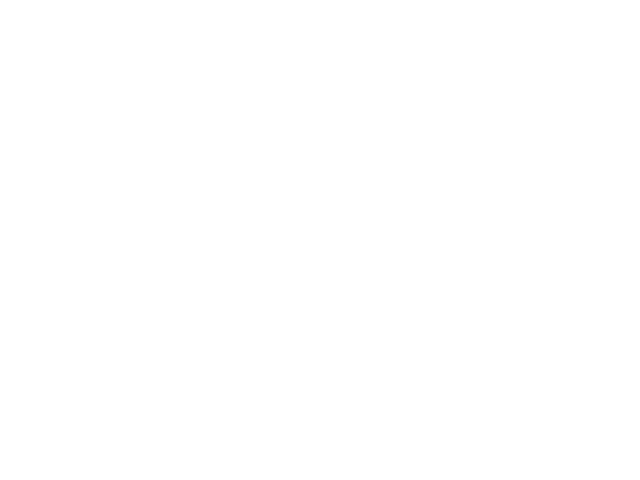

<IPython.core.display.Javascript object>


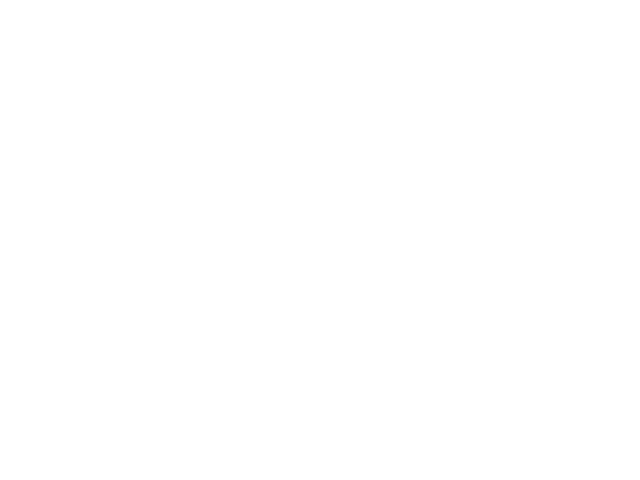

<IPython.core.display.Javascript object>


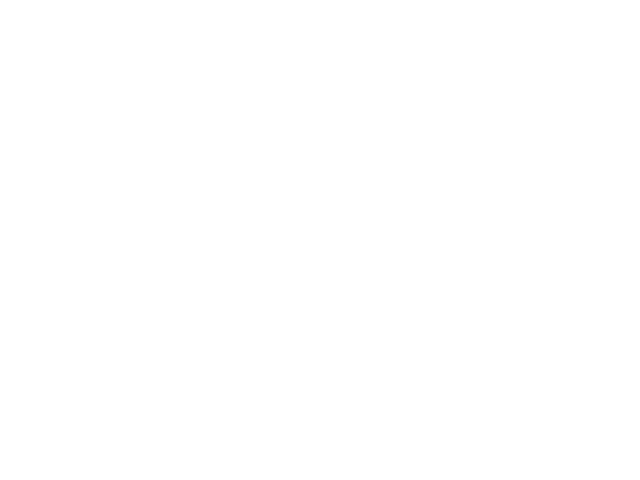

<IPython.core.display.Javascript object>


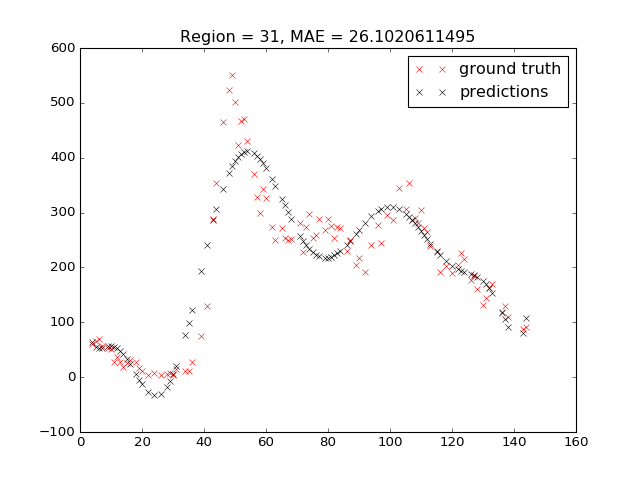

<IPython.core.display.Javascript object>


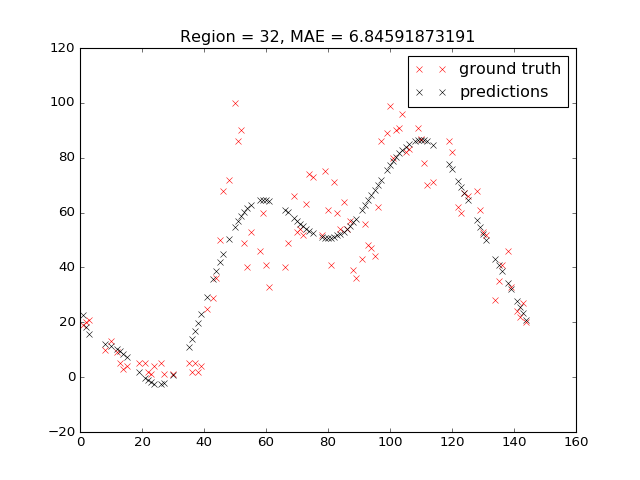

<IPython.core.display.Javascript object>


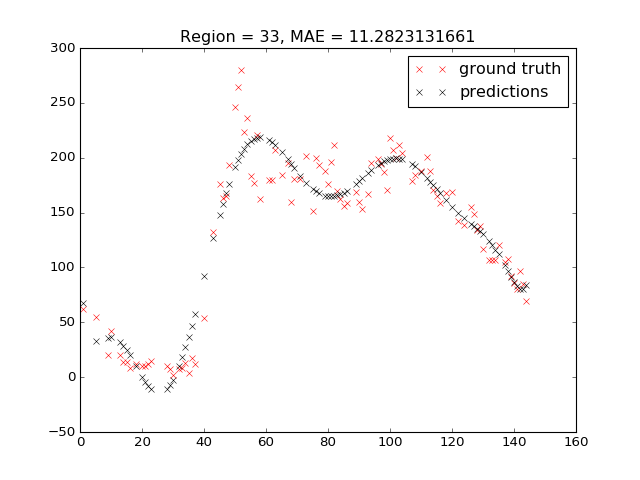

<IPython.core.display.Javascript object>


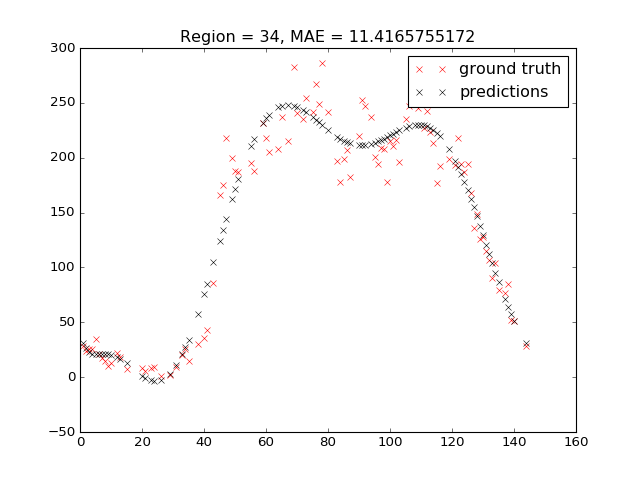

<IPython.core.display.Javascript object>


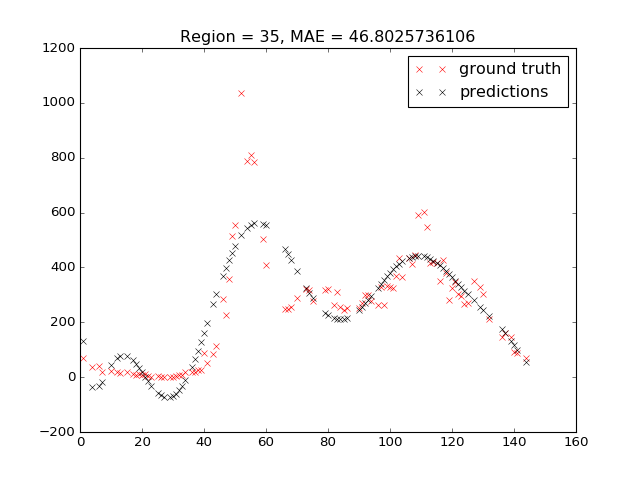

<IPython.core.display.Javascript object>


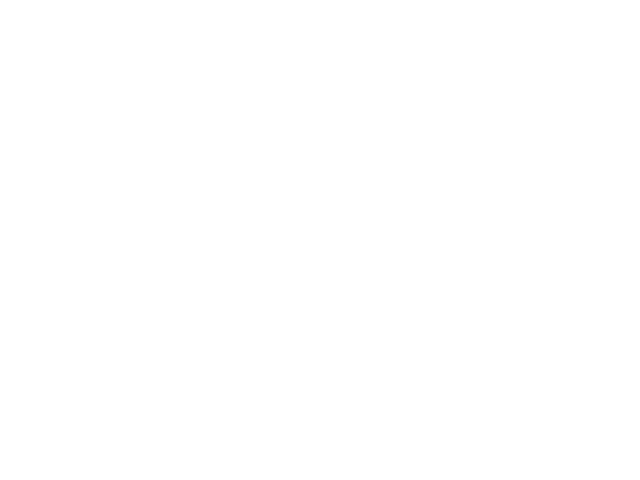

<IPython.core.display.Javascript object>


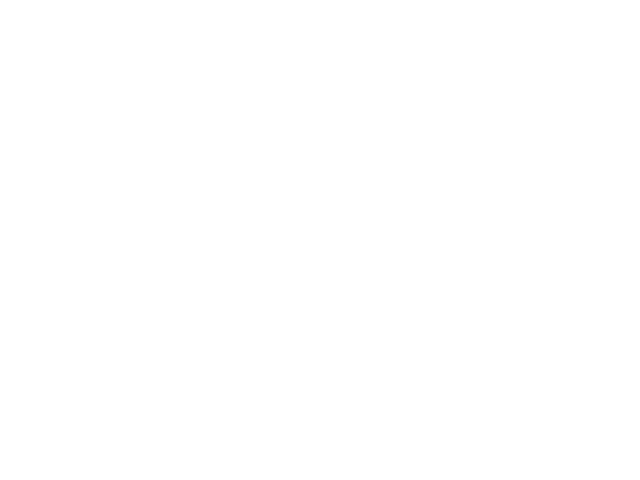

<IPython.core.display.Javascript object>


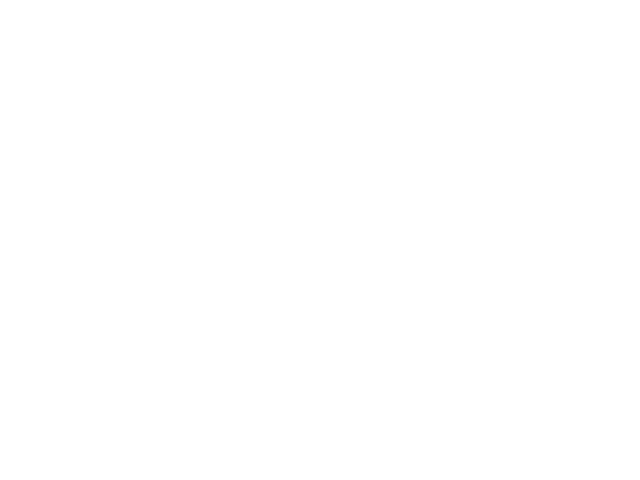

<IPython.core.display.Javascript object>


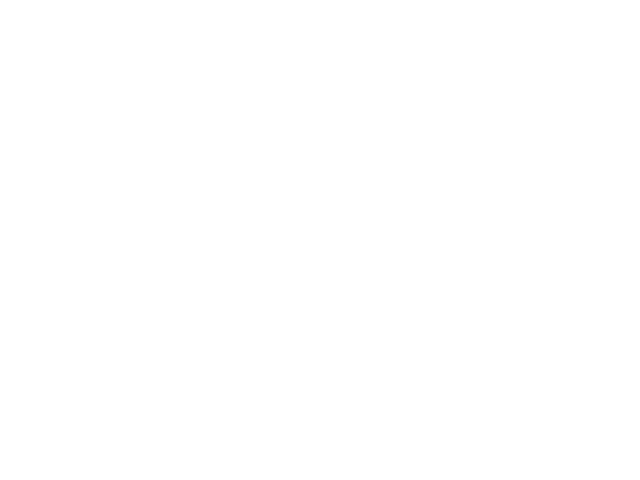

<IPython.core.display.Javascript object>


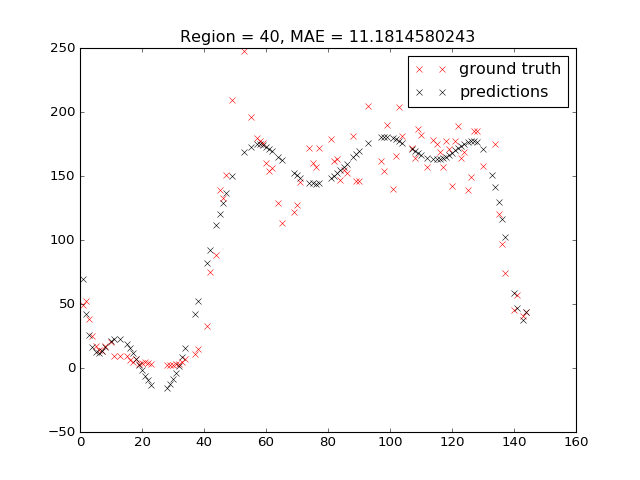

<IPython.core.display.Javascript object>


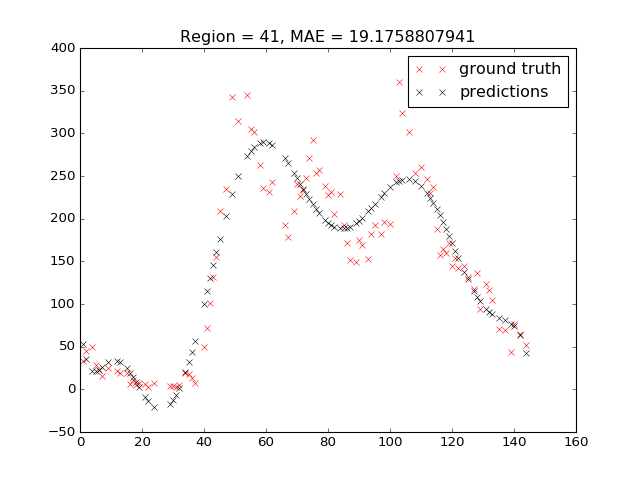

<IPython.core.display.Javascript object>


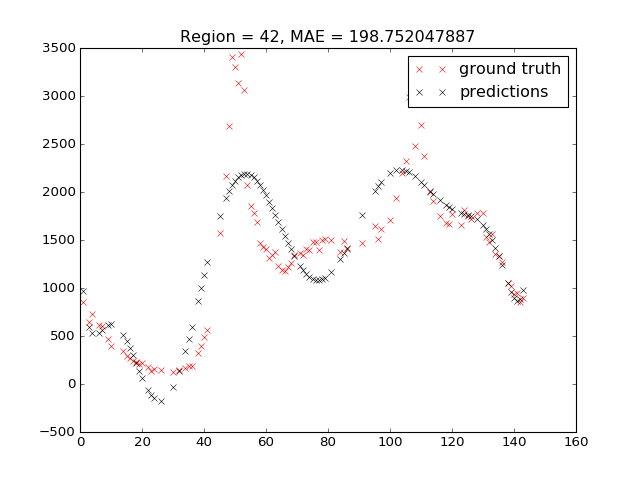

<IPython.core.display.Javascript object>


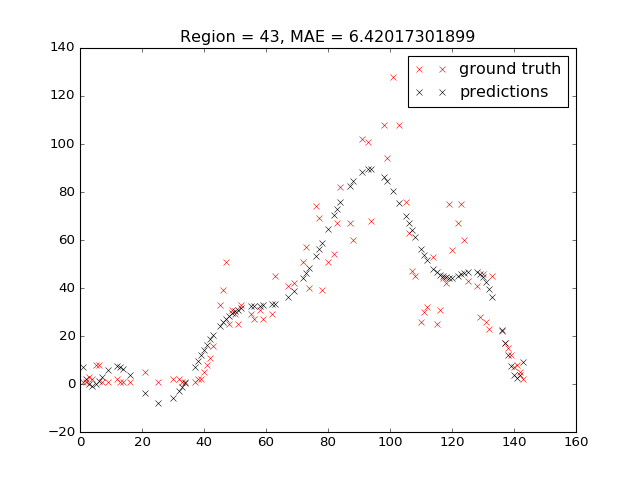

<IPython.core.display.Javascript object>


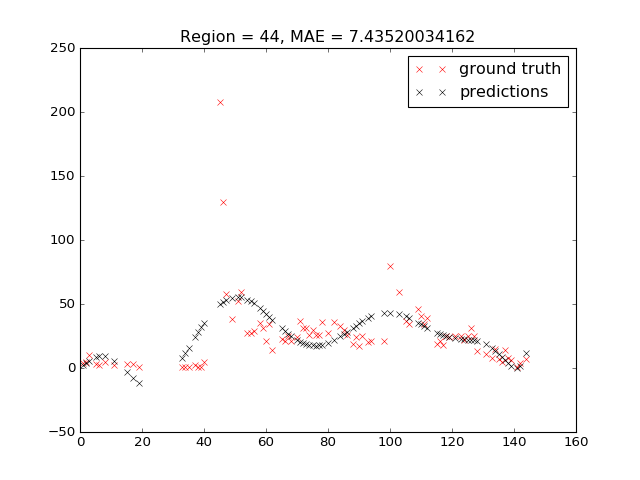

<IPython.core.display.Javascript object>


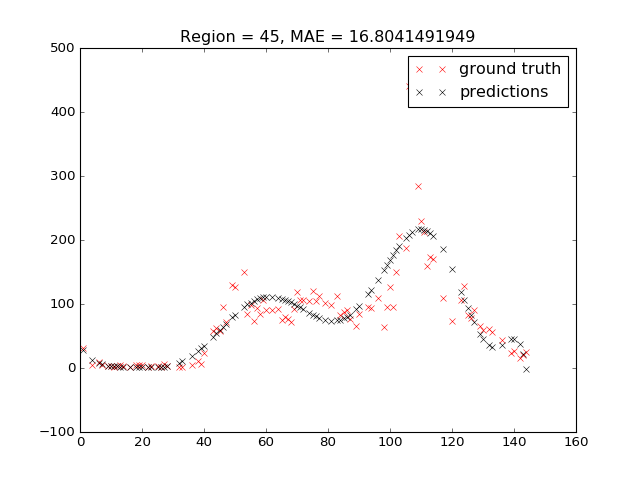

<IPython.core.display.Javascript object>


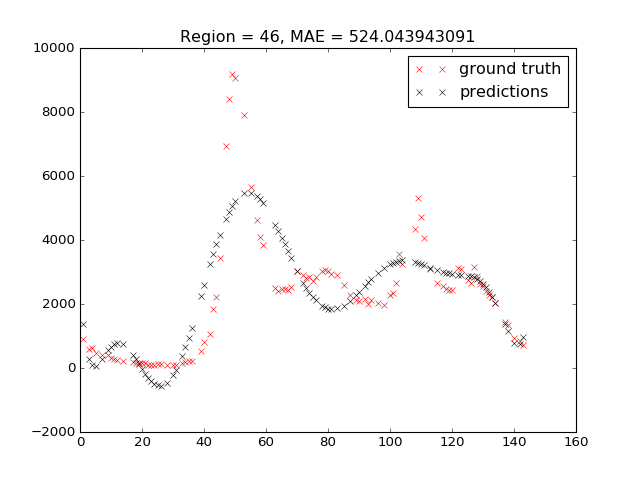

<IPython.core.display.Javascript object>


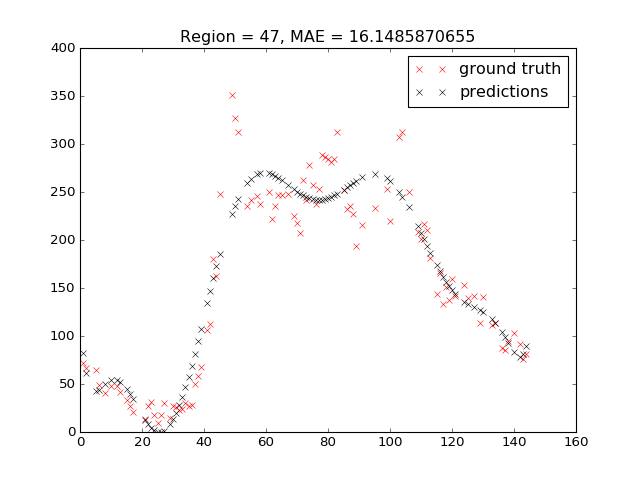

<IPython.core.display.Javascript object>


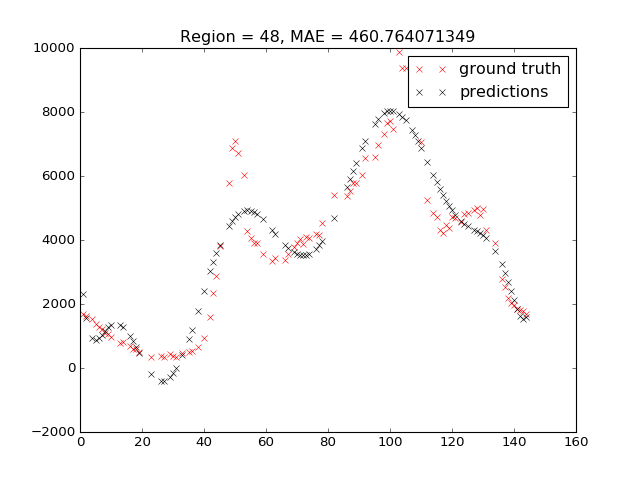

<IPython.core.display.Javascript object>


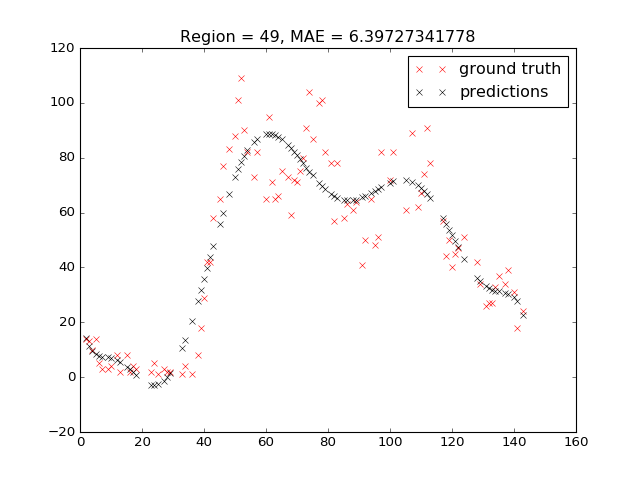

<IPython.core.display.Javascript object>


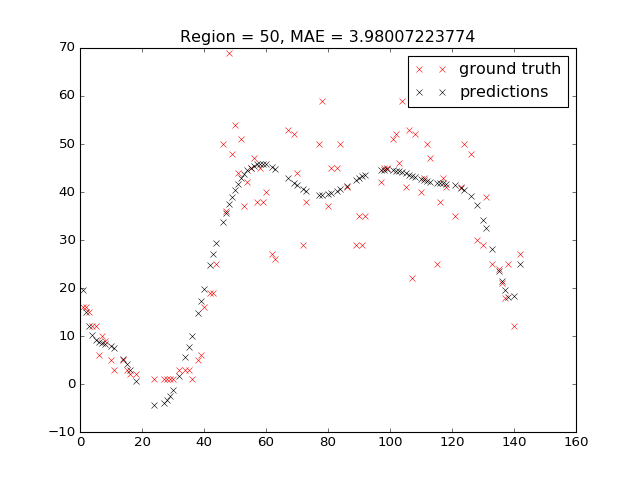

<IPython.core.display.Javascript object>


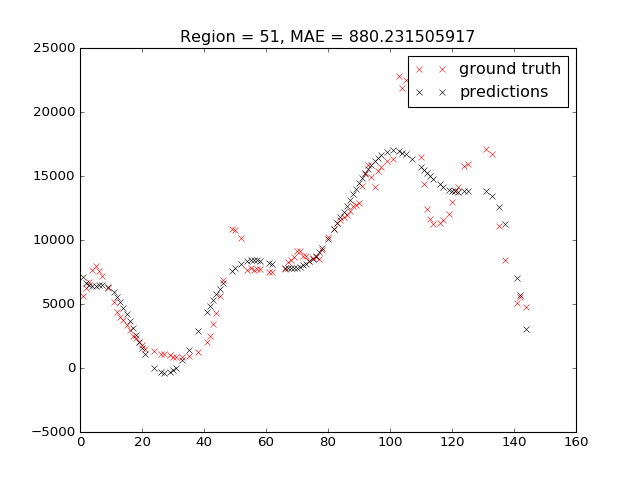

<IPython.core.display.Javascript object>


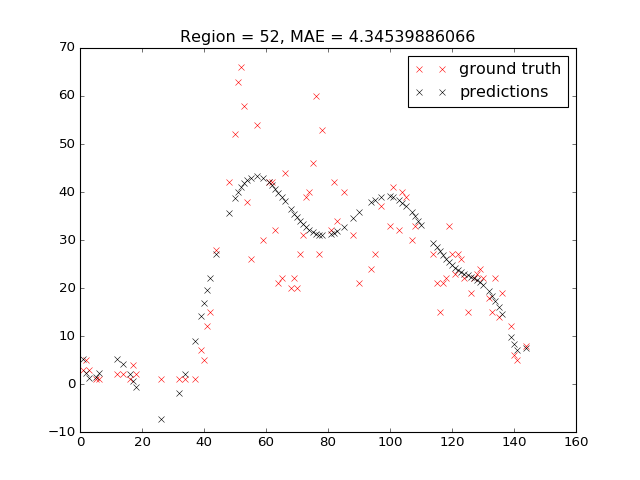

<IPython.core.display.Javascript object>


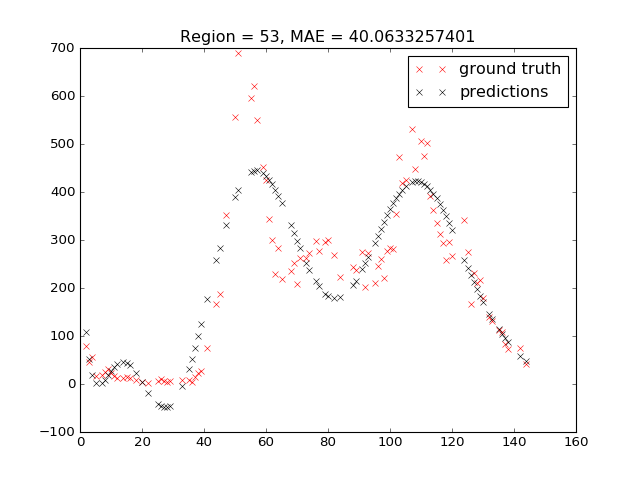

<IPython.core.display.Javascript object>


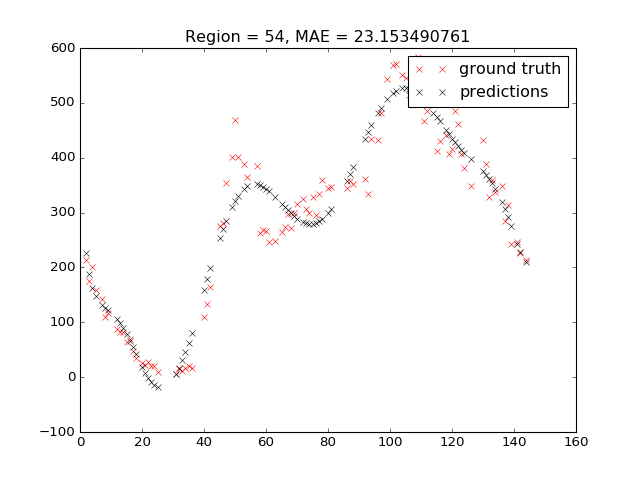

<IPython.core.display.Javascript object>


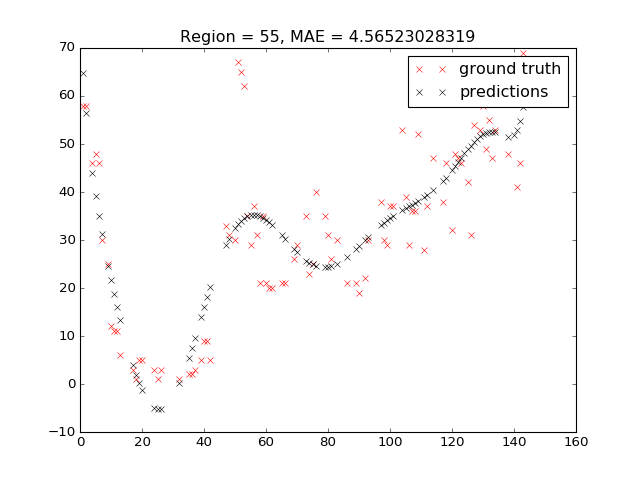

<IPython.core.display.Javascript object>


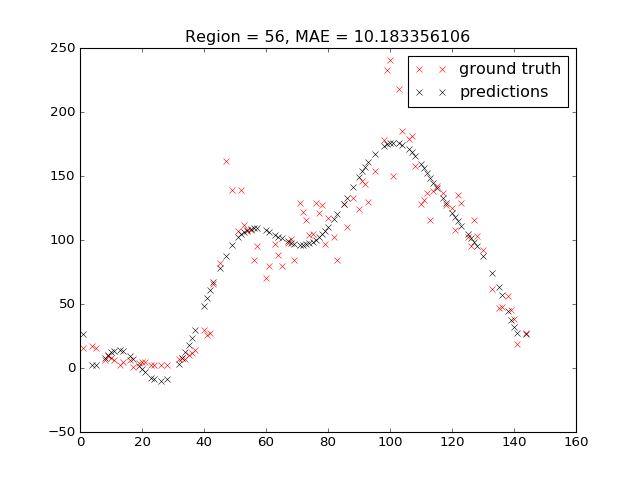

<IPython.core.display.Javascript object>


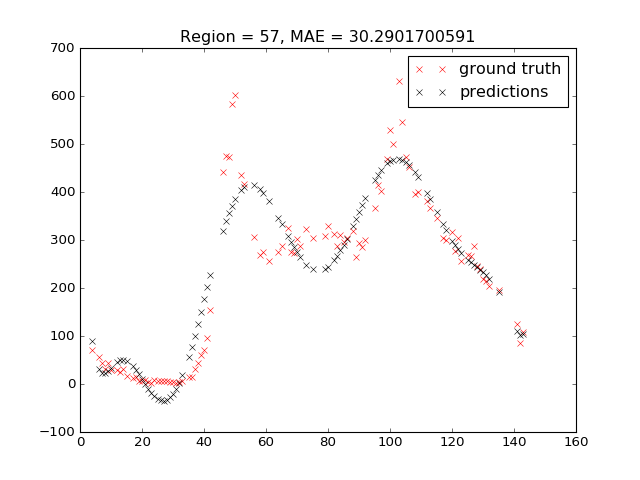

<IPython.core.display.Javascript object>


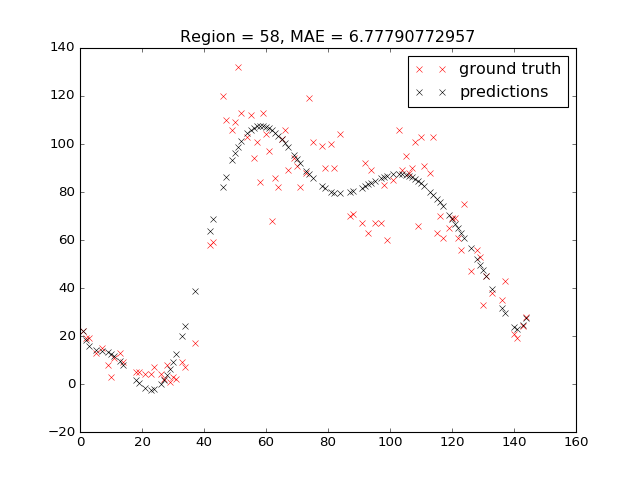

<IPython.core.display.Javascript object>


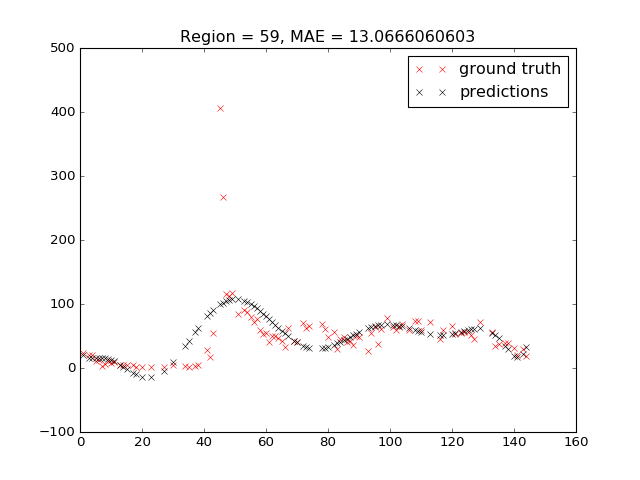

<IPython.core.display.Javascript object>


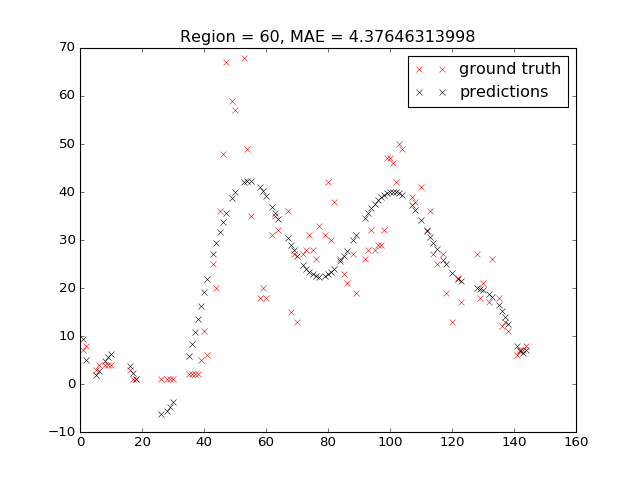

<IPython.core.display.Javascript object>


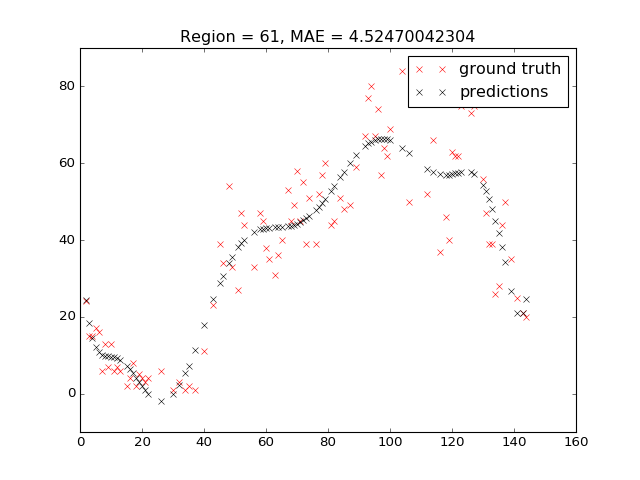

<IPython.core.display.Javascript object>


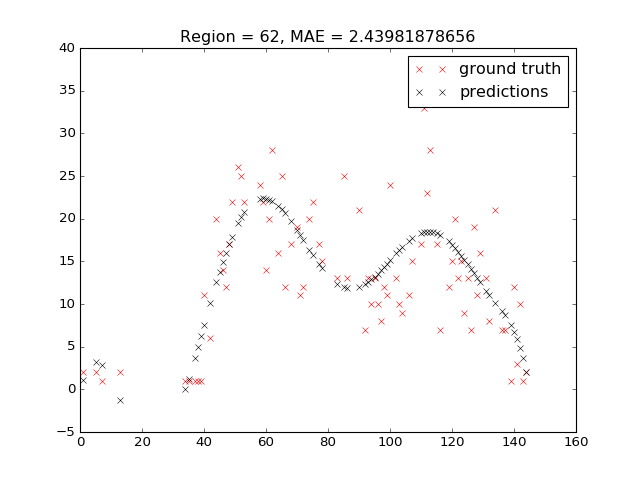

<IPython.core.display.Javascript object>


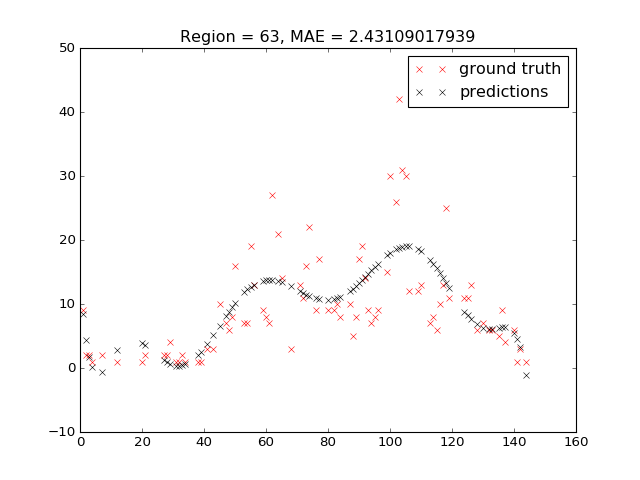

<IPython.core.display.Javascript object>


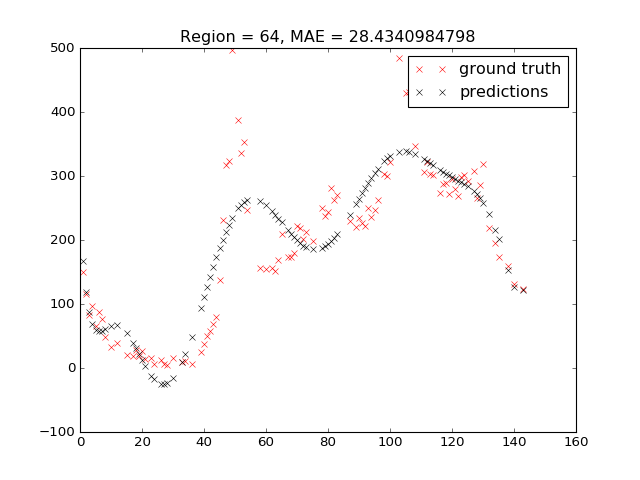

<IPython.core.display.Javascript object>


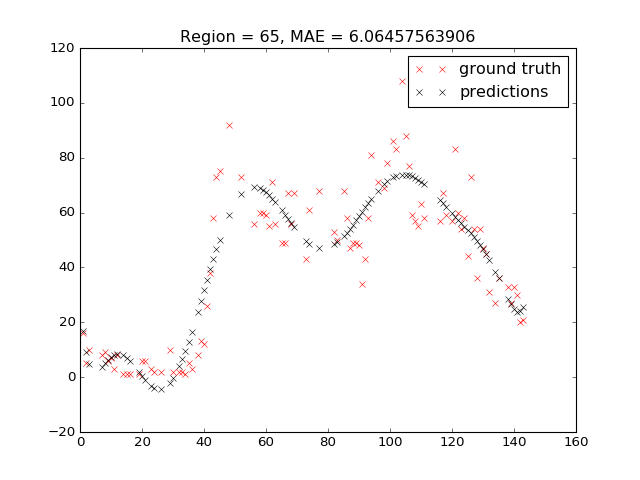

<IPython.core.display.Javascript object>


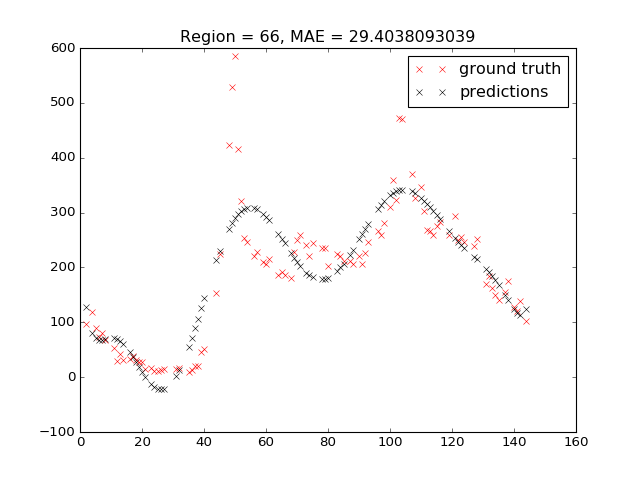

In [44]:
for r in regions: 
    Xr, supplyr, demandr = Xtrain[Xtrain[:, 0]==r, 1], supplyTrain[Xtrain[:, 0]==r], demandTrain[Xtrain[:, 0]==r]
    
    poly = PolynomialFeatures(degree=10)
    Xrnew = poly.fit_transform(Xr[:, np.newaxis])
    
    model = linear_model.Ridge(alpha=.05)
    ypreds = model.fit(Xrnew, demandr).predict(Xrnew)
    
    #print getMAE(demandr, ypreds) 
    fig, ax = plt.subplots()
    #print Xr.shape 
    ax.plot(Xr, demandr, 'rx', label='ground truth')
    ax.plot(Xr, ypreds, 'kx', label='predictions')
    ax.set_title('Region = {}, MAE = {}'.format(r, getMAE(demandr, ypreds)))
    ax.legend()
    print 